In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle/

# Copy the kaggle.json file from your Google Drive to the .kaggle directory
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json

# Set the correct permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 90% 326M/361M [00:00<00:00, 388MB/s]
100% 361M/361M [00:00<00:00, 420MB/s]


In [ ]:
!unzip /content/brain-tumor-multimodal-image-ct-and-mri.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (10).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (100).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1000).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1001).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1002).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1003).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1004).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1005).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1006).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1007).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1008).jpg  
  inflating: Dataset/Brain Tumo

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
ct_scan_base_path = '/content/Dataset/Brain Tumor CT scan Images'
categories = ["Healthy","Tumor"]
mri_scan_base_path = '/content/Dataset/Brain Tumor MRI images'

In [ ]:
# Define the specific image names for the tumor images
sample_ct_tumor_image_name = "ct_tumor (9).jpg"
sample_mri_tumor_image_name = "tumor (9).jpg"

# Construct the full paths
sample_ct_tumor_image_path = os.path.join(ct_scan_base_path, "Tumor", sample_ct_tumor_image_name)
sample_mri_tumor_image_path = os.path.join(mri_scan_base_path, "Tumor", sample_mri_tumor_image_name)

# Print the constructed paths
print(f"Sample CT Tumor Image Path: {sample_ct_tumor_image_path}")
print(f"Sample MRI Tumor Image Path: {sample_mri_tumor_image_path}")

Sample CT Tumor Image Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (9).jpg
Sample MRI Tumor Image Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (9).jpg


# Task
Modify the data loading and processing to handle paired CT and MRI images, ensuring that corresponding images are loaded together for training, validation, and testing.

In [ ]:
import os
import pandas as pd

def load_image_paths_and_labels(base_path, categories, limit_per_category=None):
    """
    Loads image paths and their corresponding labels from specified directories.

    Args:
        base_path (str): The base directory containing category subfolders.
        categories (list): A list of category names (subfolder names).
        limit_per_category (int, optional): Maximum number of images to load per category.
                                            Defaults to None (load all).

    Returns:
        pandas.DataFrame: A DataFrame with 'image_path' and 'label' columns.
    """
    image_paths = []
    labels = []

    for category in categories:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category path not found: {category_path}")
            continue

        images = os.listdir(category_path)
        if limit_per_category is not None:
            images = images[:limit_per_category]

        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            # Basic check to ensure it's a file (not a directory)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(category)

    return pd.DataFrame({
        "image_path": image_paths,
        "label": labels
    })

# Load CT image data
ct_scan_base_path = '/content/Dataset/Brain Tumor CT scan Images'
categories = ["Healthy","Tumor"]
ct_df = load_image_paths_and_labels(ct_scan_base_path, categories, limit_per_category=2000)

# Load MRI image data (assuming similar structure)
mri_scan_base_path = '/content/Dataset/Brain Tumor MRI images'
mri_df = load_image_paths_and_labels(mri_scan_base_path, categories, limit_per_category=2000) # Applying same limit as CT

print("CT DataFrame Head:")
display(ct_df.head())
print("\nMRI DataFrame Head:")
display(mri_df.head())

CT DataFrame Head:


,image_path,label
0,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
1,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
2,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
3,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
4,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy



MRI DataFrame Head:


,image_path,label
0,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
1,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
2,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
3,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
4,/content/Dataset/Brain Tumor MRI images/Health...,Healthy


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(dataframe, label_column='label'):
    """
    Encodes categorical labels into numerical format.

    Args:
        dataframe (pandas.DataFrame): The DataFrame containing the label column.
        label_column (str): The name of the column with categorical labels.

    Returns:
        tuple: A tuple containing:
            - pandas.DataFrame: The DataFrame with an added 'category_encoded' column.
            - sklearn.preprocessing.LabelEncoder: The fitted LabelEncoder object.
    """
    label_encoder = LabelEncoder()
    dataframe['category_encoded'] = label_encoder.fit_transform(dataframe[label_column])
    return dataframe, label_encoder

# Encode labels for both CT and MRI dataframes (although they should be the same categories)
ct_df, label_encoder_ct = encode_labels(ct_df.copy()) # Use .copy() to avoid modifying original df
mri_df, label_encoder_mri = encode_labels(mri_df.copy()) # Use .copy() to avoid modifying original df

# Keep only necessary columns
ct_df = ct_df[['image_path', 'category_encoded']]
mri_df = mri_df[['image_path', 'category_encoded']]

print("CT DataFrame after encoding:")
display(ct_df.head())
print("\nMRI DataFrame after encoding:")
display(mri_df.head())

# Note: The label encoders should be identical since the categories are the same.
# We can use either label_encoder_ct or label_encoder_mri for inverse transform later.

CT DataFrame after encoding:


,image_path,category_encoded
0,/content/Dataset/Brain Tumor CT scan Images/He...,0
1,/content/Dataset/Brain Tumor CT scan Images/He...,0
2,/content/Dataset/Brain Tumor CT scan Images/He...,0
3,/content/Dataset/Brain Tumor CT scan Images/He...,0
4,/content/Dataset/Brain Tumor CT scan Images/He...,0



MRI DataFrame after encoding:


,image_path,category_encoded
0,/content/Dataset/Brain Tumor MRI images/Health...,0
1,/content/Dataset/Brain Tumor MRI images/Health...,0
2,/content/Dataset/Brain Tumor MRI images/Health...,0
3,/content/Dataset/Brain Tumor MRI images/Health...,0
4,/content/Dataset/Brain Tumor MRI images/Health...,0


In [ ]:
import re
import os
import pandas as pd

def create_paired_dataframe(ct_df, mri_df, categories, ct_base_path, mri_base_path):
    """
    Creates a DataFrame of paired CT and MRI image paths based on filename patterns.

    Args:
        ct_df (pandas.DataFrame): DataFrame with CT image paths and encoded categories.
        mri_df (pandas.DataFrame): DataFrame with MRI image paths and encoded categories.
        categories (list): List of category names.
        ct_base_path (str): Base path for CT images.
        mri_base_path (str): Base path for MRI images.


    Returns:
        pandas.DataFrame: A DataFrame with 'ct_image_path', 'mri_image_path',
                          and 'category_encoded' columns for paired images.
    """
    paired_image_paths = []
    mri_path_lookup = {}

    # Create a lookup dictionary for MRI paths based on filename and category
    for index, row in mri_df.iterrows():
        mri_path = row['image_path']
        mri_filename = os.path.basename(mri_path)
        category_encoded = row['category_encoded']
        category_name = categories[category_encoded]
        mri_path_lookup[(category_name, mri_filename)] = mri_path

    # Iterate through CT images and find corresponding MRI images
    for index, row in ct_df.iterrows():
        ct_image_path = row['image_path']
        category_encoded = row['category_encoded']
        category_name = categories[category_encoded]

        ct_filename = os.path.basename(ct_image_path)
        # Extract the number from the CT filename (e.g., '9' from 'ct_tumor (9).jpg')
        match = re.search(r'\((\d+)\)', ct_filename)

        mri_image_path = None

        if match:
            number = match.group(1)
            if category_name == "Tumor":
                # Expected MRI filename format for Tumor: tumor (X).jpg
                mri_filename_candidate = f"tumor ({number}).jpg"
            elif category_name == "Healthy":
                # Expected MRI filename format for Healthy: mri_healthy (X).jpg
                mri_filename_candidate = f"mri_healthy ({number}).jpg"

            # Check if the corresponding MRI file exists using the lookup
            if (category_name, mri_filename_candidate) in mri_path_lookup:
                 mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate)]
            else:
                # Handle cases where the filename pattern might differ
                # For example, some healthy CT images are .png and some healthy MRI are .jpg
                # Let's check for healthy MRI images with the same number but .jpg extension
                if category_name == "Healthy":
                    mri_filename_candidate_jpg = f"mri_healthy ({number}).jpg"
                    if (category_name, mri_filename_candidate_jpg) in mri_path_lookup:
                        mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate_jpg)]
                    # Also check for healthy CT .png and healthy MRI .png
                    elif ct_filename.endswith('.png'):
                         mri_filename_candidate_png = f"mri_healthy ({number}).png"
                         if (category_name, mri_filename_candidate_png) in mri_path_lookup:
                             mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate_png)]


        # If a corresponding MRI image path was found, add the pair
        if mri_image_path is not None:
            paired_image_paths.append({
                'ct_image_path': ct_image_path,
                'mri_image_path': mri_image_path,
                'category_encoded': category_encoded
            })
        else:
            # Optional: Print a warning for unpaired images
            # print(f"Warning: Could not find paired MRI for CT: {ct_image_path}")
            pass


    return pd.DataFrame(paired_image_paths)

# Create the paired dataframe
paired_df = create_paired_dataframe(ct_df, mri_df, categories, ct_scan_base_path, mri_scan_base_path)


print("Paired DataFrame Head:")
display(paired_df.head())
print("\nPaired DataFrame Shape:")
print(paired_df.shape)

Paired DataFrame Head:


,ct_image_path,mri_image_path,category_encoded
0,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
1,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
2,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
3,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
4,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0



Paired DataFrame Shape:
(2425, 3)


In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
from torchvision import transforms

class PairedBrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        ct_img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ct_image_path')]
        mri_img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('mri_image_path')]
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('category_encoded')]

        ct_image = cv2.imread(ct_img_path, cv2.IMREAD_GRAYSCALE)
        mri_image = cv2.imread(mri_img_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            print(f"Warning: Could not load CT image at {ct_img_path}")
            ct_image_tensor = torch.zeros(1, 128, 128) # Dummy tensor
        else:
            if self.transform:
                ct_image_tensor = self.transform(ct_image)
            else:
                ct_image_tensor = torch.from_numpy(ct_image).unsqueeze(0).float() / 255.0 # Basic conversion

        if mri_image is None:
            print(f"Warning: Could not load MRI image at {mri_img_path}")
            mri_image_tensor = torch.zeros(1, 128, 128) # Dummy tensor
        else:
            if self.transform:
                mri_image_tensor = self.transform(mri_image)
            else:
                mri_image_tensor = torch.from_numpy(mri_image).unsqueeze(0).float() / 255.0 # Basic conversion

        # Return dummy label (-1) if either image failed to load
        if ct_image is None or mri_image is None:
             label = -1

        return ct_image_tensor, mri_image_tensor, label

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
from torchvision import transforms
import numpy as np

# Define image transformations
# These transformations should be applied consistently to both CT and MRI images
# You can define a single transform and apply it to both images in the dataset class
# Added Data Augmentation transforms
transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((128, 128)), # Resize to a consistent size
    transforms.RandomRotation(degrees=15), # Randomly rotate by +/- 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=0.5), # Randomly flip vertically
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Randomly adjust brightness and contrast
    # Add other transformations here if needed (e.g., RandomAffine, RandomPerspective)
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    # Add other transformations here if needed (e.g., normalization)
    # transforms.Normalize(mean=[0.5], std=[0.5]) # Example normalization for grayscale
])

# Assuming PairedBrainTumorDataset class is defined in cell 7cc01600

# Split paired_df
# Use stratify to ensure the proportion of classes is the same in train, validation, and test sets
train_paired_df, temp_paired_df = train_test_split(paired_df, test_size=0.3, random_state=42, stratify=paired_df['category_encoded'])
valid_paired_df, test_paired_df = train_test_split(temp_paired_df, test_size=0.5, random_state=42, stratify=temp_paired_df['category_encoded'])

# Create paired datasets
train_paired_dataset = PairedBrainTumorDataset(train_paired_df, transform=transform)
valid_paired_dataset = PairedBrainTumorDataset(valid_paired_df, transform=transform)
test_paired_dataset = PairedBrainTumorDataset(test_paired_df, transform=transform)

print("Paired Datasets:")
print("Train:", len(train_paired_dataset))
print("Validation:", len(valid_paired_dataset))
print("Test:", len(test_paired_dataset))

Paired Datasets:
Train: 1697
Validation: 364
Test: 364


In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders for paired datasets
batch_size = 16

train_paired_loader = DataLoader(train_paired_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Added num_workers
valid_paired_loader = DataLoader(valid_paired_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Added num_workers
test_paired_loader = DataLoader(test_paired_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Added num_workers

print("Paired DataLoaders:")
print("Train batches:", len(train_paired_loader))
print("Validation batches:", len(valid_paired_loader))
print("Test batches:", len(test_paired_loader))

Paired DataLoaders:
Train batches: 107
Validation batches: 23
Test batches: 23


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Encoder
class CNNEncoder(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, embed_dim, 3, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(2).transpose(1, 2)  # [B, N_patches, D]
        return x

# Cross-Attention Block returns (output_tensor, attention_weights)
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim*2, embed_dim)
        )

    def forward(self, x, y):
        # x attends to y
        attn_out, attn_weights = self.cross_attn(query=x, key=y, value=y, need_weights=True)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.ff(x))
        return x, attn_weights # Return attention weights

# Lightweight Dual-Modal Model with Dual Cross-Attention
class LightweightDualCrossModalTransformer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct  = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # CLS tokens
        self.cls_ct  = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.cls_mri = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Self-Attention per modality (lightweight)
        self.self_attn_ct  = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Dual Cross-Attention
        self.cross_ct_to_mri = CrossAttentionBlock(embed_dim, num_heads)  # MRI attends to CT
        self.cross_mri_to_ct = CrossAttentionBlock(embed_dim, num_heads)  # CT attends to MRI

        # LayerNorms
        self.ln_ct  = nn.LayerNorm(embed_dim)
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(embed_dim*2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        B = ct_img.size(0)
        # print(f"Input batch size (B): {B}")

        # CNN embeddings
        ct  = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)
        # print(f"CT CNN output shape: {ct.shape}")
        # print(f"MRI CNN output shape: {mri.shape}")

        # CLS tokens
        ct  = torch.cat([self.cls_ct.expand(B, -1, -1), ct], dim=1)
        mri = torch.cat([self.cls_mri.expand(B, -1, -1), mri], dim=1)
        # print(f"CT with CLS token shape: {ct.shape}")
        # print(f"MRI with CLS token shape: {mri.shape}")

        # Self-attention
        ct  = self.self_attn_ct(ct)
        mri = self.self_attn_mri(mri)
        # print(f"CT Self-attention output shape: {ct.shape}")
        # print(f"MRI Self-attention output shape: {mri.shape}")

        # Dual Cross-Attention Weights
        # CT attends to MRI
        ct, ct_mri_attn_weights = self.cross_mri_to_ct(ct, mri)
        # MRI attends to CT
        mri, mri_ct_attn_weights = self.cross_ct_to_mri(mri, ct)
        # print(f"CT after Cross-attention shape: {ct.shape}")
        # print(f"MRI after Cross-attention shape: {mri.shape}")
        # print(f"CT-MRI attention weights shape: {ct_mri_attn_weights.shape}")
        # print(f"MRI-CT attention weights shape: {mri_ct_attn_weights.shape}")

        # Apply CLS tokens
        ct_cls  = self.ln_ct(ct[:, 0, :])
        mri_cls = self.ln_mri(mri[:, 0, :])
        # print(f"CT CLS token shape: {ct_cls.shape}")
        # print(f"MRI CLS token shape: {mri_cls.shape}")

        # Concatenate and classify
        fused = torch.cat([ct_cls, mri_cls], dim=1)
        # print(f"Fused features shape: {fused.shape}")
        logits = self.fc(fused)
        # print(f"Logits shape: {logits.shape}")
        return logits, ct_mri_attn_weights, mri_ct_attn_weights


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------------
# Training and Validation with Early Stopping
# -------------------------------
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, weight_decay=0.0, device="cuda", patience=5):
    """
    Trains the model with early stopping.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        num_epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) for the optimizer.
        device (str): Device to train on ('cpu' or 'cuda').
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        torch.nn.Module: The trained model.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Added weight_decay

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        processed_samples_train = 0

        for ct_img, mri_img, labels in train_loader:
            # Filter out samples with invalid labels (-1)
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue # Skip batch if no valid samples

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
                continue # Skip if no valid samples remain after filtering

            optimizer.zero_grad()
            # Model now returns logits and attention weights (or just logits for ablated)
            outputs = model(ct_img, mri_img)
            if isinstance(outputs, tuple):
                 logits = outputs[0] # Extract logits if model returns tuple
            else:
                 logits = outputs # Use outputs directly if model returns only logits


            # Explicitly reshape logits to ensure [batch_size, num_classes]
            # This addresses potential squeezing issues with batch size 1
            # Assuming num_classes is 2
            if logits.ndim == 1:
                logits = logits.unsqueeze(0) # Add batch dimension if it's squeezed
            # Ensure the number of classes dimension is 2
            if logits.size(-1) != 2:
                 # This might indicate a problem with the model's output shape
                 print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2).")
                 # Attempt to reshape if possible, or raise an error
                 if logits.numel() == labels.size(0) * 2: # Check if total elements match expected [N, 2]
                      logits = logits.view(labels.size(0), 2)
                 else:
                      raise RuntimeError(f"Model output logits shape {logits.size()} is incompatible with labels size {labels.size()}.")


            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            processed_samples_train += labels.size(0)

        train_loss = running_loss / processed_samples_train if processed_samples_train > 0 else 0.0
        train_acc = correct / processed_samples_train if processed_samples_train > 0 else 0.0

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        processed_samples_val = 0
        with torch.no_grad():
            for ct_img, mri_img, labels in val_loader:
                # Filter out samples with invalid labels (-1)
                valid_indices = labels != -1
                if not torch.any(valid_indices):
                    continue # Skip batch if no valid samples

                ct_img = ct_img[valid_indices].to(device)
                mri_img = mri_img[valid_indices].to(device)
                labels = labels[valid_indices].to(device)

                if labels.size(0) == 0:
                    continue # Skip if no valid samples remain after filtering

                # Model now returns logits and attention weights (or just logits for ablated)
                outputs = model(ct_img, mri_img)
                if isinstance(outputs, tuple):
                     logits = outputs[0] # Extract logits if model returns tuple
                else:
                     logits = outputs # Use outputs directly if model returns only logits

                # Explicitly reshape logits to ensure [batch_size, num_classes]
                if logits.ndim == 1:
                    logits = logits.unsqueeze(0)
                if logits.size(-1) != 2:
                     if logits.numel() == labels.size(0) * 2:
                          logits = logits.view(labels.size(0), 2)
                     else:
                          print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2) during validation.")
                          # Cannot reshape safely, continue with potentially incorrect shape or skip loss calc
                          # For now, let's proceed but be aware of potential issues
                          pass # Allow loss calculation to proceed, might fail

                loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(logits, 1)
                correct += (preds == labels).sum().item()
                processed_samples_val += labels.size(0)

        val_loss /= processed_samples_val if processed_samples_val > 0 else 0.0
        val_acc = correct / processed_samples_val if processed_samples_val > 0 else 0.0

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping
        # Check if val_loss is valid (not NaN)
        if not isinstance(val_loss, (int, float)) or not torch.isfinite(torch.tensor(val_loss)):
             print(f"Warning: Invalid validation loss ({val_loss}) at epoch {epoch+1}. Skipping early stopping check.")
             continue # Skip early stopping for this epoch if validation loss is invalid

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss.")
                break
    return model

#  Function that evaluates the model on the test set using a paired dataloader
def evaluate_model(model, test_loader, device="cpu"):
    """
    Evaluates the model on the test set.

    Args:
        model: The PyTorch model to evaluate.
        test_loader: DataLoader for the test data.
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        float: Test accuracy.
    """
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    processed_samples_test = 0 # counter for processed samples in evaluation
    with torch.no_grad():
        for ct_img, mri_img, labels in test_loader:
            # Filter out samples with invalid labels (-1)
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue # Skip batch if no valid samples

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
                continue # Skip if no valid samples

            # Model returns logits and attention weights (or just logits for ablated)
            outputs = model(ct_img, mri_img)
            if isinstance(outputs, tuple):
                 logits = outputs[0] # Extract logits if model returns tuple
            else:
                 logits = outputs # Use outputs directly if model returns only logits

            # Explicitly reshape logits to ensure [batch_size, num_classes]
            # Assuming num_classes is 2
            if logits.ndim == 1:
                logits = logits.unsqueeze(0)
            if logits.size(-1) != 2:
                 # This might indicate a problem with the model's output shape
                 print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2) during evaluation.")
                 # Cannot reshape safely, proceed with potentially incorrect shape or skip prediction
                 pass # Allow prediction to proceed, might fail


            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            processed_samples_test += labels.size(0) # Count only processed samples

    accuracy = correct / processed_samples_test if processed_samples_test > 0 else 0.0
    return accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming LightweightDualCrossModalTransformer model class is defined (from cell Q34tveY_se4L)
# Assuming train_paired_loader and valid_paired_loader are defined (from cell bef7f23d)
# Assuming evaluate_model function is defined (from cell TkydqFnUslzv)

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate the model
model = LightweightDualCrossModalTransformer(embed_dim=64, num_heads=2, num_classes=2).to(device)

# Train the model
print("Starting training...")
# The train_model function is defined in cell TkydqFnUslzv and includes early stopping
trained_model = train_model(
    model,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20, # Example number of epochs
    lr=1e-4, # Example learning rate
    weight_decay=1e-4, # Example weight decay
    device=device,
    patience=5 # Example patience for early stopping
)
print("Training finished.")

# Save the final state of the trained model
torch.save(trained_model.state_dict(), 'full_model_final_state.pth')
print("Final trained model state saved to 'full_model_final_state.pth'")

# Evaluate the trained model
print("\nEvaluating the trained model on the test set...")
# The evaluate_model function is defined in cell TkydqFnUslzv
test_accuracy = evaluate_model(trained_model, test_paired_loader, device=device)
print(f"\nTest Accuracy: {test_accuracy:.4f}")



Using device: cpu
Starting training...


NameError: name 'train_paired_loader' is not defined

# Task
Predict and display the results for 8 sample paired images from the test set.

In [ ]:
import torch

def predict_image_pair(model, ct_image_path, mri_image_path, device="cpu"):
    """
    Predicts the label for a given CT and MRI image pair.

    Args:
        model: The trained PyTorch model.
        ct_image_path (str): Path to the CT image.
        mri_image_path (str): Path to the MRI image.
        device (str): Device to perform inference on ('cpu' or 'cuda').

    Returns:
        int: The predicted class label (0 for Healthy, 1 for Tumor),
             or None if image loading fails.
    """
    ct_image = load_and_preprocess_image(ct_image_path)
    mri_image = load_and_preprocess_image(mri_image_path)

    if ct_image is None or mri_image is None:
        return None  # Indicate error loading images

    # Add batch dimension and move to device
    ct_image = ct_image.unsqueeze(0).to(device)
    mri_image = mri_image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(ct_image, mri_image)
        _, predicted_class = torch.max(logits, 1)

    return predicted_class.item()


Calculate and display the confusion matrix, precision, recall, and F1-score using the true and predicted labels obtained in the previous step.



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import torch

# 1. Initialize an empty list to store the predicted labels
all_predicted_labels = []
all_true_labels = []

# 2. Set the model to evaluation mode
trained_model.eval()

# 3. Disable gradient calculation
with torch.no_grad():
    # 4. Iterate through the test_paired_loader
    for ct_img, mri_img, labels in test_paired_loader:
        # 5. Move the CT and MRI images and labels to the specified device
        ct_img, mri_img, labels = ct_img.to("cpu"), mri_img.to("cpu"), labels.to("cpu")

        # 6. Get the model's logits for the paired images
        # Model now returns a tuple (logits, ct_mri_attn_weights, mri_ct_attn_weights)
        model_output = trained_model(ct_img, mri_img)
        logits = model_output[0] # Extract the logits tensor

        # 7. Get the predicted class label for each image in the batch
        _, predicted_classes = torch.max(logits, 1)

        # 8. Extend the list of predicted labels with the predicted labels from the current batch
        all_predicted_labels.extend(predicted_classes.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())


# 9. Convert the list of predicted labels to a NumPy array
all_predicted_labels = np.array(all_predicted_labels)

# 10. Extract the true labels from the test_paired_df and store them in a NumPy array.
# This was already done by appending labels in the loop, so just convert the list.
all_true_labels = np.array(all_true_labels)

print("Predicted labels obtained for the test set.")

Predicted labels obtained for the test set.


In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Confusion Matrix:
[[299   1]
 [ 11  53]]

Precision: 0.9815
Recall:    0.8281
F1-score:  0.8983



Calculate and plot the ROC curve and AUC score using the true labels and the model's predicted probabilities (logits) for the positive class.



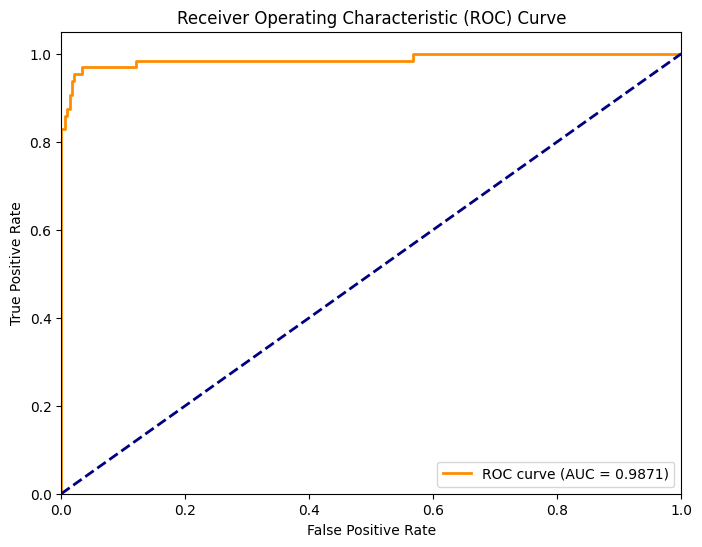

AUC: 0.9871


In [ ]:
# To calculate ROC curve and AUC, we need the predicted probabilities (logits)
# We need to re-run the prediction loop to get the logits

all_logits = []
trained_model.eval()
with torch.no_grad():
    for ct_img, mri_img, labels in test_paired_loader:
        ct_img, mri_img = ct_img.to("cpu"), mri_img.to("cpu")
        # Model now returns a tuple (logits, ct_mri_attn_weights, mri_ct_attn_weights)
        model_output = trained_model(ct_img, mri_img)
        logits = model_output[0] # Extract the logits tensor
        all_logits.extend(logits.cpu().numpy())

all_logits = np.array(all_logits)

# Get the probabilities for the positive class (class 1)
all_probabilities = torch.softmax(torch.tensor(all_logits), dim=1)[:, 1].numpy()


# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_true_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [ ]:
sample_paired_images_df = test_paired_df.head(8)

sample_ct_image_paths = sample_paired_images_df['ct_image_path'].tolist()
sample_mri_image_paths = sample_paired_images_df['mri_image_path'].tolist()
sample_true_labels = sample_paired_images_df['category_encoded'].tolist()

print("Selected Sample Paired Image Paths and True Labels:")
for i in range(len(sample_paired_images_df)):
    print(f"Sample {i+1}:")
    print(f"  CT Path: {sample_ct_image_paths[i]}")
    print(f"  MRI Path: {sample_mri_image_paths[i]}")
    print(f"  True Label: {sample_true_labels[i]}")
    print("-" * 20)

Selected Sample Paired Image Paths and True Labels:
Sample 1:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (24).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (24).jpg
  True Label: 1
--------------------
Sample 2:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (45).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (45).jpg
  True Label: 0
--------------------
Sample 3:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (892).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (892).jpg
  True Label: 0
--------------------
Sample 4:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (349).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (349).jpg
  True Label: 0
--------------------
Sample 5:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (1255).jpg
  MRI Path: /cont

In [ ]:
# Select sample paired images for visualization
# Find indices for healthy and tumor cases in the test_paired_df
healthy_indices = test_paired_df[test_paired_df['category_encoded'] == 0].index.tolist()
tumor_indices = test_paired_df[test_paired_df['category_encoded'] == 1].index.tolist()

sample_indices_viz = []

# Select samples (to get an equal number of healthy and tumor)
num_samples_to_select = 6 #

# Add healthy samples
num_healthy_to_select = min(num_samples_to_select // 2, len(healthy_indices))
sample_indices_viz.extend(healthy_indices[:num_healthy_to_select])

# Add tumor samples
num_tumor_to_select = min(num_samples_to_select - len(sample_indices_viz), len(tumor_indices))
sample_indices_viz.extend(tumor_indices[:num_tumor_to_select])

# If not enough samples of one class, fill with the other class
if len(sample_indices_viz) < num_samples_to_select:
    remaining_needed = num_samples_to_select - len(sample_indices_viz)
    if len(sample_indices_viz) < len(healthy_indices):
        # Add more healthy samples if available
        healthy_indices_remaining = [idx for idx in healthy_indices if idx not in sample_indices_viz]
        sample_indices_viz.extend(healthy_indices_remaining[:remaining_needed])
        remaining_needed = num_samples_to_select - len(sample_indices_viz)
    if remaining_needed > 0 and len(sample_indices_viz) < len(tumor_indices):
         # Add more tumor samples if available
        tumor_indices_remaining = [idx for idx in tumor_indices if idx not in sample_indices_viz]
        sample_indices_viz.extend(tumor_indices_remaining[:remaining_needed])


# Ensure unique indices and shuffle for variety (optional)
sample_indices_viz = list(set(sample_indices_viz))
# random.shuffle(sample_indices_viz) # Uncomment if you want random samples each time

sample_paired_images_viz_df = test_paired_df.loc[sample_indices_viz]

sample_ct_image_paths_viz = sample_paired_images_viz_df['ct_image_path'].tolist()
sample_mri_image_paths_viz = sample_paired_images_viz_df['mri_image_path'].tolist()
sample_true_labels_viz = sample_paired_images_viz_df['category_encoded'].tolist()

print("Selected Sample Paired Image Paths and True Labels for Visualization:")
for i in range(len(sample_paired_images_viz_df)):
    print(f"Sample {i}:")
    print(f"  CT Path: {sample_ct_image_paths_viz[i]}")
    print(f"  MRI Path: {sample_mri_image_paths_viz[i]}")
    print(f"  True Label: {sample_true_labels_viz[i]} ({categories[sample_true_labels_viz[i]]})")
    print("-" * 20)



Selected Sample Paired Image Paths and True Labels for Visualization:
Sample 0:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (109).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (109).jpg
  True Label: 1 (Tumor)
--------------------
Sample 1:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (95).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (95).jpg
  True Label: 1 (Tumor)
--------------------
Sample 2:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (349).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (349).jpg
  True Label: 0 (Healthy)
--------------------
Sample 3:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (45).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (45).jpg
  True Label: 0 (Healthy)
--------------------
Sample 4:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor

## Implement Grad-CAM

### Subtask:
Implement the Grad-CAM technique to generate heatmaps highlighting important regions in the input images.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def visualize_attention_map(original_image_path, attention_weights, patch_size=16, grid_size=None, img_size=(128, 128), title="Attention Map"):
    """
    Visualizes attention weights as a heatmap overlaid on the original image.

    Args:
        original_image_path (str): Path to the original image.
        attention_weights (torch.Tensor): Attention weights for a single image pair (shape [seq_len_query, seq_len_key]).
                                         Assuming B=1 for prediction and batch dimension is removed.
                                         We'll visualize attention of CLS token to patches.
        patch_size (int): Size of the square patches used in the CNN.
        grid_size (int, optional): Number of patches along one side (assuming square grid).
                                   If None, it will be inferred from the number of patches.
        img_size (tuple): Size of the input image (width, height).
        title (str): Title for the plot.
    """
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Warning: Could not load image for visualization at {original_image_path}")
        return

    original_image = cv2.resize(original_image, img_size)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB) # Convert to RGB for heatmap overlay

    # Assuming attention_weights is shape [seq_len_query, seq_len_key] after removing batch dim
    # Select the attention weights from the CLS token (index 0) to the patches (indices 1 onwards)
    if attention_weights.ndim == 2:
        # Find the row corresponding to the CLS token (usually the first one)
        # and select the attention weights to the patch tokens (usually from index 1 onwards).
        # The exact indices might depend on how CLS tokens and patches are concatenated
        # and which sequence is the key in the cross-attention.
        # For CT attending to MRI (ct_mri_attn): query=CT, key=MRI. Shape [seq_len_ct, seq_len_mri]
        # We want CT CLS (index 0 of query) attending to MRI patches (indices 1+ of key).
        # So, attention_weights[0, 1:]
        attention = attention_weights[0, 1:] # Shape [num_patches_key]
        num_patches = attention.shape[0]

        if grid_size is None:
             # Infer grid size from the number of patches
             grid_size_actual = int(np.sqrt(num_patches))
             if grid_size_actual * grid_size_actual != num_patches:
                  print(f"Warning: Number of patches ({num_patches}) is not a perfect square. Cannot reshape attention for visualization.")
                  return
             grid_size = grid_size_actual
        else:
            # Use provided grid_size, but verify it matches the number of patches
            if grid_size * grid_size != num_patches:
                print(f"Warning: Provided grid_size ({grid_size}) does not match the number of patches ({num_patches}). Cannot reshape attention for visualization.")
                return


        attention_grid = attention.reshape(grid_size, grid_size).cpu().detach().numpy()

        # Resize heatmap to match image size
        heatmap = cv2.resize(attention_grid, img_size)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(superimposed_img)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
         print(f"Warning: Attention weights shape is not as expected after selecting batch item: {attention_weights.shape}")


def visualize_gradcam_heatmap(original_image_path, heatmap, img_size=(128, 128), title="Grad-CAM Heatmap"):
    """
    Visualizes Grad-CAM heatmap overlaid on the original image.

    Args:
        original_image_path (str): Path to the original image.
        heatmap (np.ndarray): Grad-CAM heatmap (shape [height, width]).
        img_size (tuple): Size the original image was resized to (width, height).
        title (str): Title for the plot.
    """
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Warning: Could not load image for visualization at {original_image_path}")
        return

    original_image = cv2.resize(original_image, img_size)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB) # Convert to RGB for heatmap overlay

    # Resize the heatmap to the original image size (or the processed image size)
    # Ensure heatmap is 2D
    if heatmap.ndim > 2:
        print(f"Warning: Grad-CAM heatmap is not 2D (shape {heatmap.shape}). Cannot resize for visualization.")
        return

    heatmap_resized = cv2.resize(heatmap, img_size)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
import cv2
import torch
from torchvision import transforms

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """
    Loads and preprocesses a single image.

    Args:
        image_path (str): Path to the image file.
        img_size (tuple): Desired output image size (width, height).

    Returns:
        torch.Tensor: Preprocessed image tensor, or None if loading fails.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Warning: Could not load image at {image_path}")
        return None

    # Resize the image
    image = cv2.resize(image, img_size)

    # Convert to tensor and normalize
    image_tensor = torch.from_numpy(image).unsqueeze(0).float() / 255.0 # Add channel dimension and normalize
    return image_tensor

import torch

def predict_image_pair_with_attention(model, ct_image_path, mri_image_path, device="cpu"):
    """
    Predicts the label and returns attention weights for a given CT and MRI image pair.

    Args:
        model: The trained PyTorch model (modified to return attention weights).
        ct_image_path (str): Path to the CT image.
        mri_image_path (str): Path to the MRI image.
        device (str): Device to perform inference on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing:
            - int: The predicted class label (0 for Healthy, 1 for Tumor),
                   or None if image loading fails.
            - torch.Tensor: Attention weights from CT attending to MRI (shape [batch_size, num_heads, seq_len_ct, seq_len_mri]),
                            or None if image loading fails.
            - torch.Tensor: Attention weights from MRI attending to CT (shape [batch_size, num_heads, seq_len_mri, seq_len_ct]),
                            or None if image loading fails.
    """
    ct_image = load_and_preprocess_image(ct_image_path)
    mri_image = load_and_preprocess_image(mri_image_path)

    if ct_image is None or mri_image is None:
        return None, None, None  # Indicate error loading images

    # Add batch dimension and move to device
    ct_image = ct_image.unsqueeze(0).to(device)
    mri_image = mri_image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        model_output = model(ct_image, mri_image)
        # print(f"Model output type: {type(model_output)}") # Keep for debugging if needed
        # print(f"Model output: {model_output}") # Keep for debugging if needed

        # Attempt to unpack the first three elements, assuming the model output
        # can be treated as a sequence of at least three elements.
        try:
            # Explicitly cast to tuple before unpacking
            model_output_tuple = tuple(model_output)
            logits, ct_mri_attn_weights, mri_ct_attn_weights = model_output_tuple
            _, predicted_class = torch.max(logits, 1)
            return predicted_class.item(), ct_mri_attn_weights, mri_ct_attn_weights
        except (TypeError, ValueError, IndexError) as e:
            print(f"Error unpacking model output: {e}")
            print(f"Model output type: {type(model_output)}")
            print(f"Model output: {model_output}")
            return None, None, None # Return None if unpacking fails


Define a function to implement Grad-CAM. This function will require registering hooks to the model's layers to capture gradients and feature maps.


Generating predictions, attention weights, and Grad-CAM heatmaps for sample images
Predictions, attention weights, and Grad-CAM heatmaps generated for sample images.

Visualizing results for sample images

--- Sample 1: True Label: Tumor, Predicted Label: Tumor ---


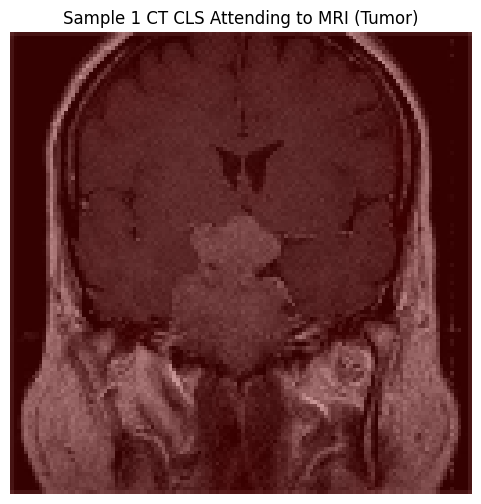

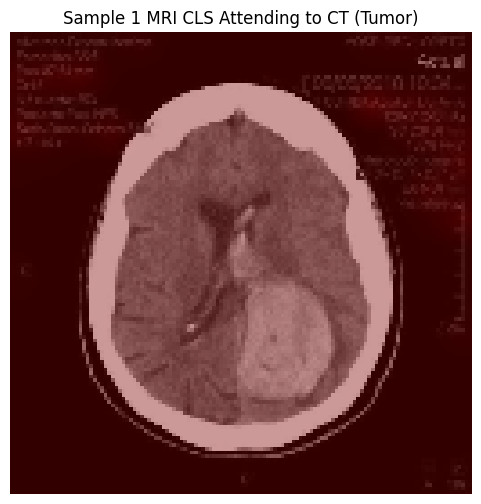

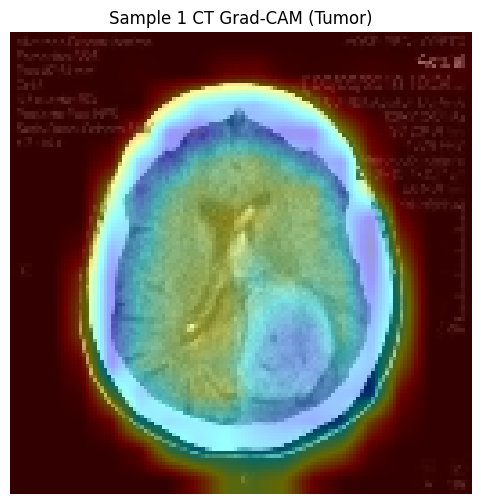

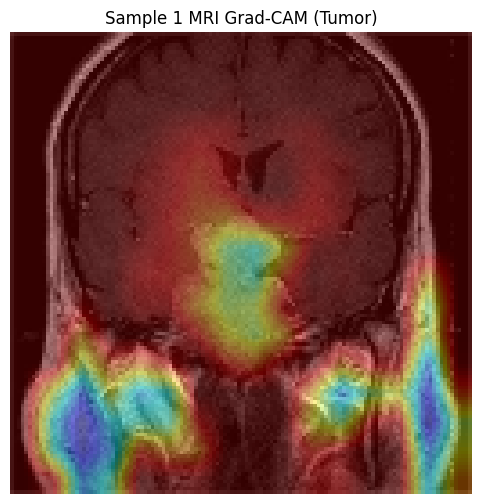


--- Sample 2: True Label: Tumor, Predicted Label: Tumor ---


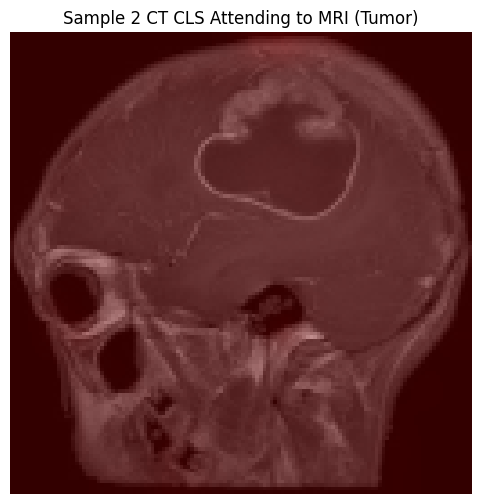

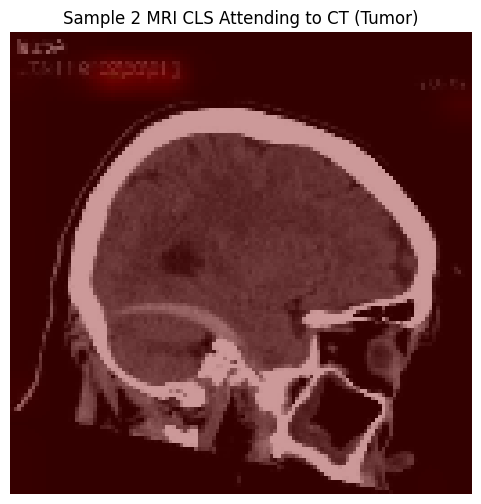

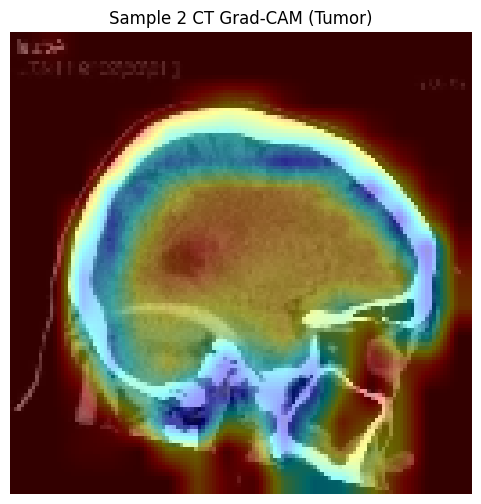

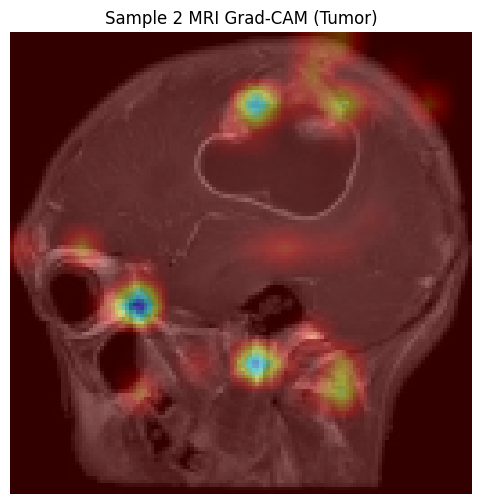


--- Sample 3: True Label: Healthy, Predicted Label: Healthy ---


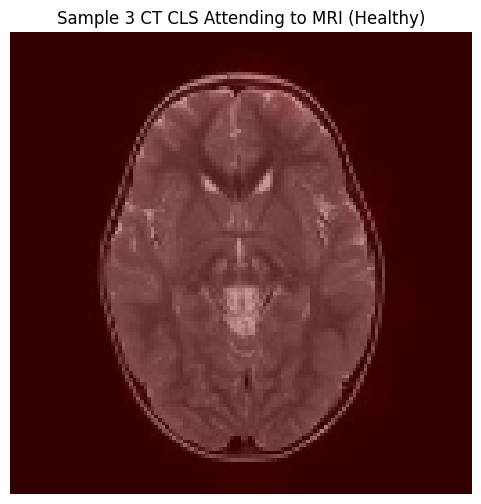

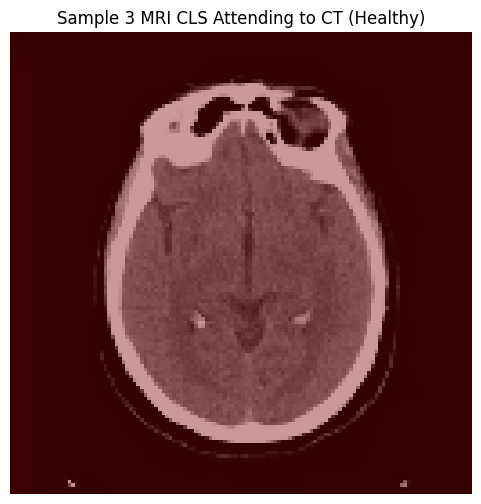

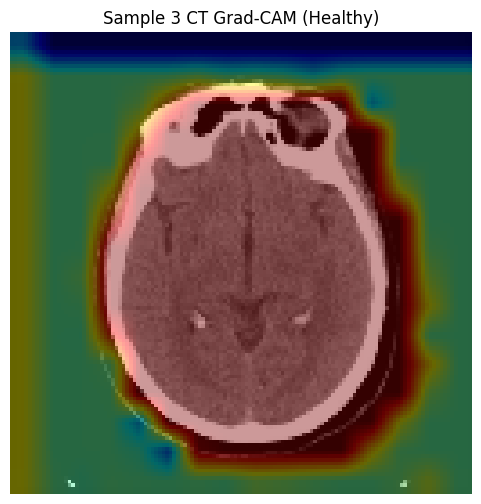

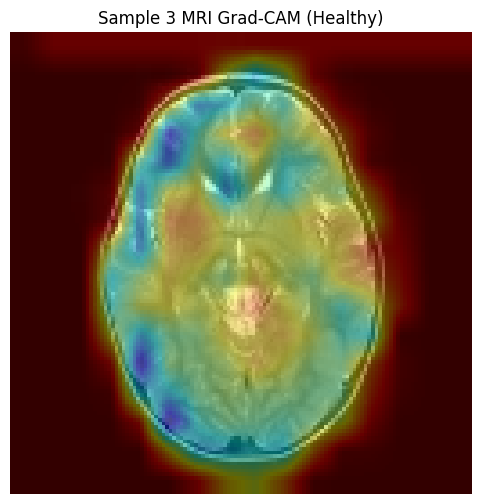


--- Sample 4: True Label: Healthy, Predicted Label: Healthy ---


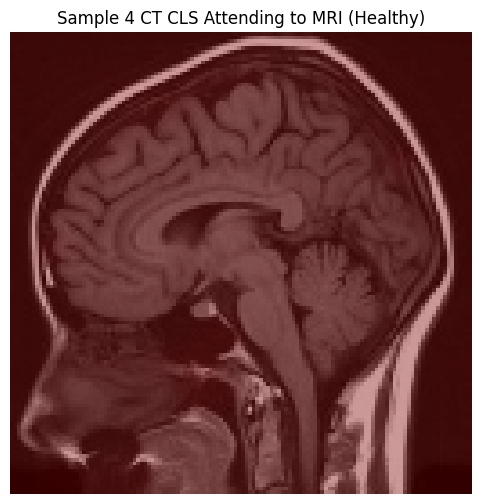

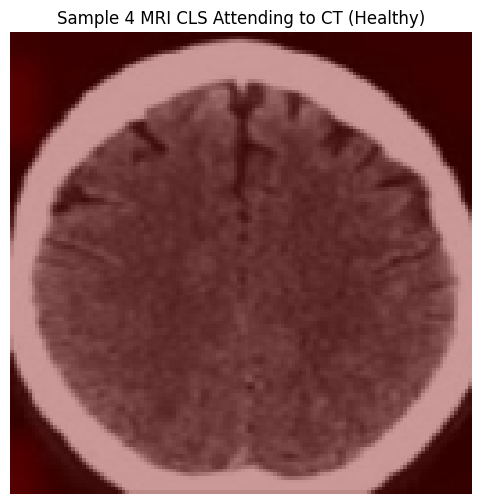

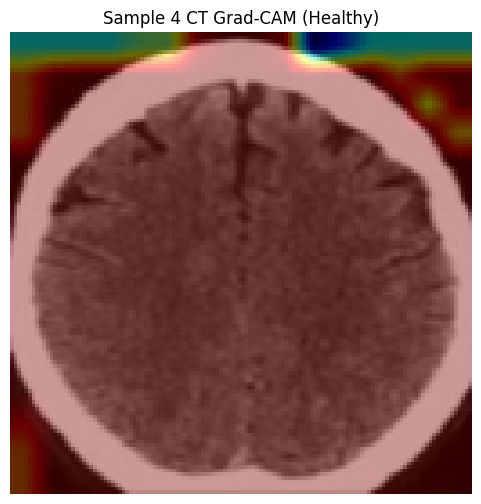

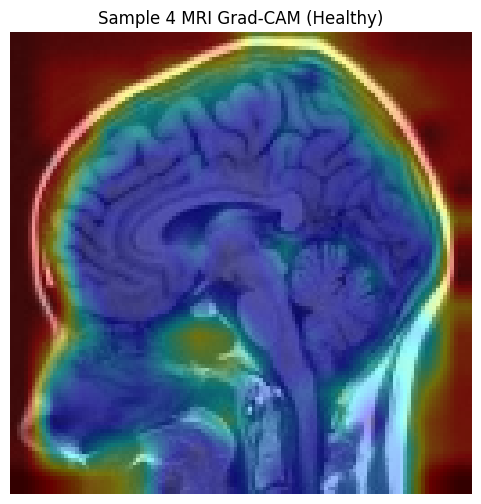


--- Sample 5: True Label: Tumor, Predicted Label: Tumor ---


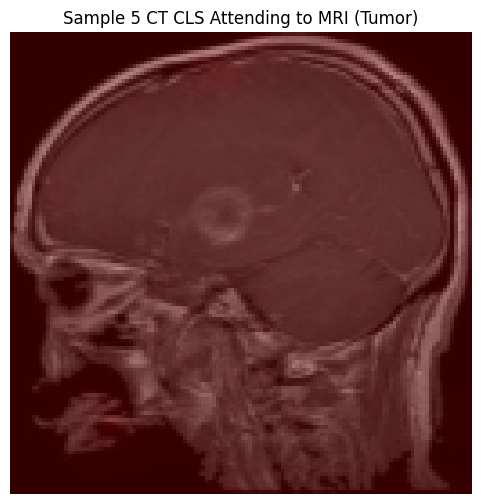

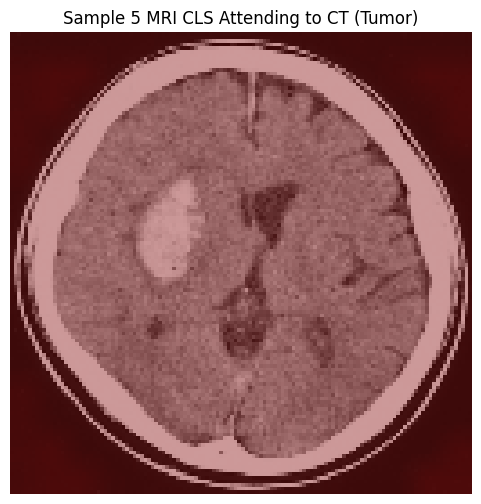

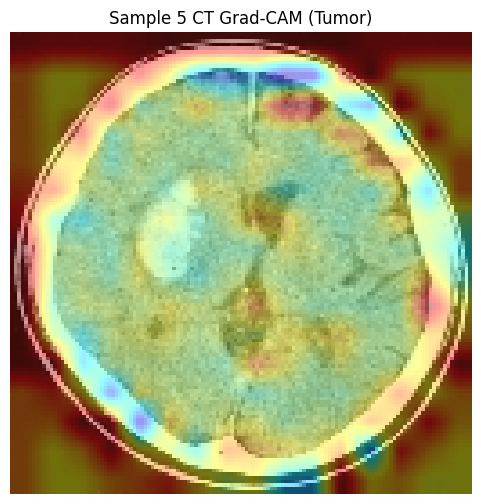

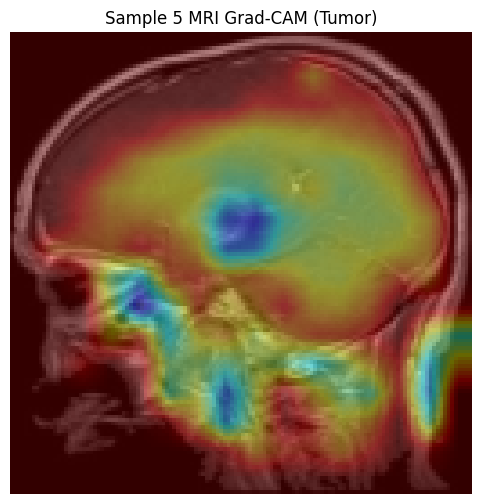


--- Sample 6: True Label: Healthy, Predicted Label: Healthy ---


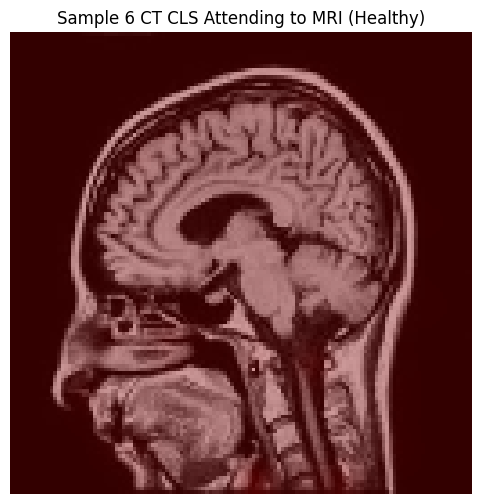

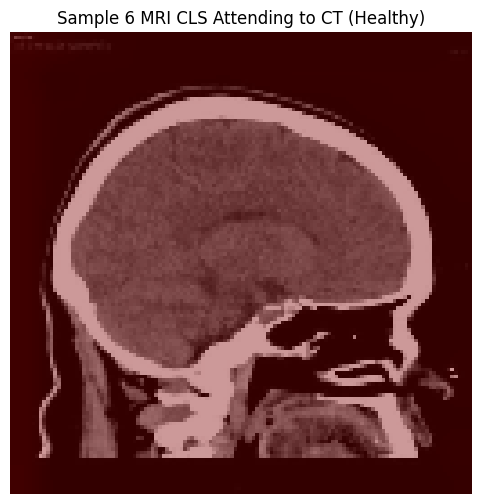

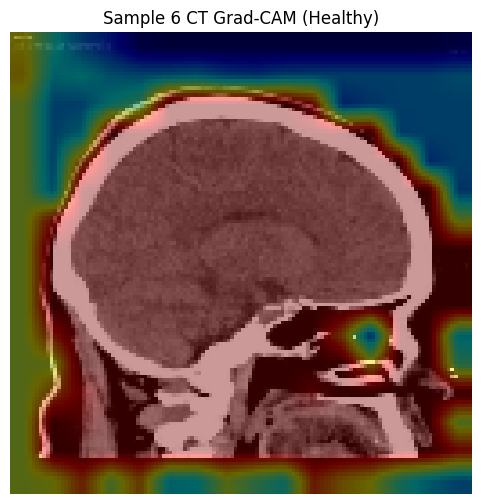

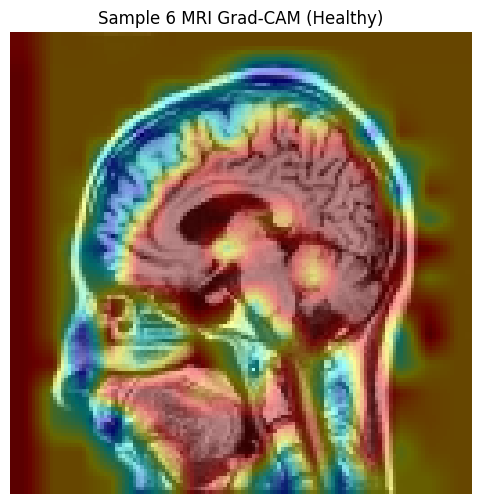

In [ ]:
# Initialize Grad-CAM instances for both the CT and MRI encoders
# Selecting the last convolutional layer in each encoder as the target layer
grad_cam_ct = GradCAM(trained_model, trained_model.cnn_ct.conv[-1])
grad_cam_mri = GradCAM(trained_model, trained_model.cnn_mri.conv[-1])

sample_results = []

# Iterate through the selected sample paired images:
print("\nGenerating predictions, attention weights, and Grad-CAM heatmaps for sample images")
for i in range(len(sample_paired_images_viz_df)):
    ct_path = sample_ct_image_paths_viz[i]
    mri_path = sample_mri_image_paths_viz[i]
    true_label = sample_true_labels_viz[i]

    # Use the predict_image_pair_with_attention function to get the predicted label and attention weights
    predicted_label, ct_mri_attn, mri_ct_attn = predict_image_pair_with_attention(trained_model, ct_path, mri_path, device=device)

    ct_heatmap = None
    mri_heatmap = None

    # If the prediction was successful (predicted label is not None), load and preprocess the images separately for Grad-CAM.
    if predicted_label is not None:
        ct_image_tensor = load_and_preprocess_image(ct_path).unsqueeze(0).to(device)
        mri_image_tensor = load_and_preprocess_image(mri_path).unsqueeze(0).to(device)

        if ct_image_tensor is not None and mri_image_tensor is not None:
             # c. Generate Grad-CAM heatmaps for both the CT and MRI images
             # Pass both tensors to Grad-CAM __call__ as a tuple
             ct_heatmap, _ = grad_cam_ct((ct_image_tensor, mri_image_tensor), target_category=predicted_label)
             mri_heatmap, _ = grad_cam_mri((ct_image_tensor, mri_image_tensor), target_category=predicted_label)
        else:
            print(f"Warning: Could not load preprocessed tensors for Grad-CAM for sample {i+1}.")


    # Store the results
    sample_results.append({
        'ct_path': ct_path,
        'mri_path': mri_path,
        'true_label': true_label,
        'predicted_label': predicted_label,
        'ct_mri_attention': ct_mri_attn,
        'mri_ct_attention': mri_ct_attn,
        'ct_heatmap': ct_heatmap,
        'mri_heatmap': mri_heatmap
    })

print("Predictions, attention weights, and Grad-CAM heatmaps generated for sample images.")

# Iterate through the stored sample results and visualize:
print("\nVisualizing results for sample images")
categories = ["Healthy", "Tumor"]

for i, result in enumerate(sample_results):
    ct_path = result['ct_path']
    mri_path = result['mri_path']
    ct_mri_attn = result['ct_mri_attention']
    mri_ct_attn = result['mri_ct_attention']
    ct_heatmap = result['ct_heatmap']
    mri_heatmap = result['mri_heatmap']
    true_label = result['true_label']
    predicted_label = result['predicted_label']

    if predicted_label is not None:
        predicted_label_name = categories[predicted_label]
    else:
        predicted_label_name = "N/A (Image Load Error)"

    print(f"\n--- Sample {i+1}: True Label: {categories[true_label]}, Predicted Label: {predicted_label_name} ---")

    # Visualize attention maps
    if ct_mri_attn is not None and ct_mri_attn.ndim == 3:
         visualize_attention_map(
             mri_path, # Overlay on MRI image (as CT is attending to MRI)
             ct_mri_attn.squeeze(0), # Remove batch dim
             patch_size=16, grid_size=16, img_size=(128, 128),
             title=f"Sample {i+1} CT CLS Attending to MRI ({predicted_label_name})"
         )
    else:
         print(f"Could not visualize CT CLS attention to MRI for Sample {i+1}. Attention weights shape: {ct_mri_attn.shape if ct_mri_attn is not None else 'None'}")


    if mri_ct_attn is not None and mri_ct_attn.ndim == 3:
        visualize_attention_map(
            ct_path, # Overlay on CT image (as MRI is attending to CT)
            mri_ct_attn.squeeze(0),
            patch_size=16, grid_size=16, img_size=(128, 128),
            title=f"Sample {i+1} MRI CLS Attending to CT ({predicted_label_name})"
        )
    else:
        print(f"Could not visualize MRI CLS attention to CT for Sample {i+1}. Attention weights shape: {mri_ct_attn.shape if mri_ct_attn is not None else 'None'}")


    # Visualize Grad-CAM heatmaps
    if ct_heatmap is not None:
         visualize_gradcam_heatmap(
             ct_path,
             ct_heatmap,
             img_size=(128, 128),
             title=f"Sample {i+1} CT Grad-CAM ({predicted_label_name})"
         )
    else:
         print(f"Could not visualize CT Grad-CAM heatmap for Sample {i+1}.")


    if mri_heatmap is not None:
        visualize_gradcam_heatmap(
            mri_path,
            mri_heatmap,
            img_size=(128, 128),
            title=f"Sample {i+1} MRI Grad-CAM ({predicted_label_name})"
        )
    else:
        print(f"Could not visualize MRI Grad-CAM heatmap for Sample {i+1}.")

# Task
Improve the model performance by applying regularization, hyperparameter tuning, and cross-validation, then retrain and evaluate the model.

## Implement regularization

### Subtask:
Add regularization techniques (e.g., weight decay) to the model's optimizer.


Using device: cuda

Starting Hyperparameter Tuning with Grid Search over 16 combinations (without K-Fold)...

--- Tuning Combination 1/16 with params: {'lr': 0.0001, 'weight_decay': 0.0, 'embed_dim': 32, 'num_heads': 1} ---
Epoch 1/20 | Train Loss: 0.4689, Train Acc: 0.8271 | Val Loss: 0.4220, Val Acc: 0.8282
Epoch 2/20 | Train Loss: 0.4117, Train Acc: 0.8302 | Val Loss: 0.4084, Val Acc: 0.8364
Epoch 3/20 | Train Loss: 0.3705, Train Acc: 0.8318 | Val Loss: 0.3258, Val Acc: 0.8571
Epoch 4/20 | Train Loss: 0.3509, Train Acc: 0.8530 | Val Loss: 0.3537, Val Acc: 0.8489
Epoch 5/20 | Train Loss: 0.3385, Train Acc: 0.8639 | Val Loss: 0.3443, Val Acc: 0.8613
Epoch 6/20 | Train Loss: 0.3313, Train Acc: 0.8639 | Val Loss: 0.3037, Val Acc: 0.8737
Epoch 7/20 | Train Loss: 0.3056, Train Acc: 0.8763 | Val Loss: 0.3001, Val Acc: 0.8923
Epoch 8/20 | Train Loss: 0.3128, Train Acc: 0.8732 | Val Loss: 0.2873, Val Acc: 0.8903
Epoch 9/20 | Train Loss: 0.2987, Train Acc: 0.8908 | Val Loss: 0.2577, Val Acc: 

/tmp/ipython-input-495415949.py:239: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  all_test_probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()


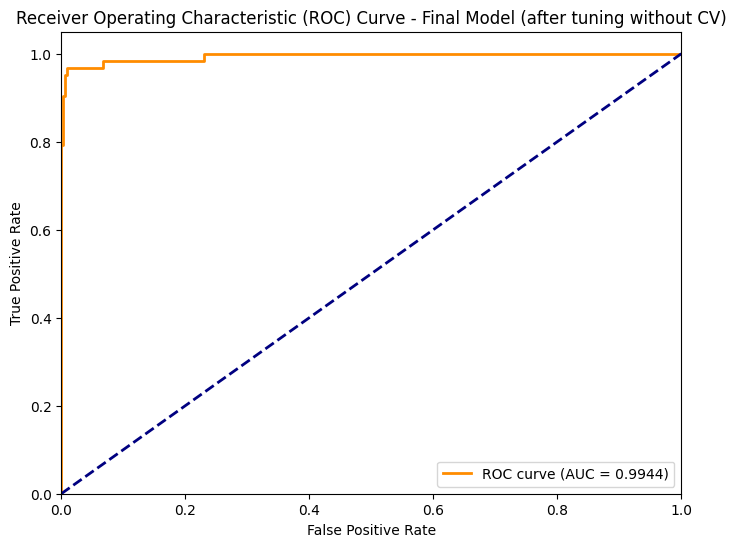

Test AUC: 0.9944


In [ ]:
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split

# Assuming PairedBrainTumorDataset, train_model, evaluate_model, LightweightDualCrossModalTransformer are defined
# Assuming paired_df and transform are available

# --- Hyperparameter Tuning (Grid Search without K-Fold) ---

# Define the hyperparameter grid
param_grid = {
    'lr': [1e-4, 5e-5], # Reduced search space for quicker example
    'weight_decay': [0.0, 1e-4], # Reduced search space
    'embed_dim': [32, 64], # Reduced search space
    'num_heads': [1, 2] # Reduced search space
    # Dropout is handled in the model definition for now
}

# Create all combinations of hyperparameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_f1 = -1 # Track best validation F1 during tuning
best_params = None
all_tuning_results = []

# Use the full paired_df for a single train/validation split for tuning
if 'paired_df' not in globals() or paired_df is None:
    print("Error: 'paired_df' not found or is None. Cannot perform hyperparameter tuning.")
else:
    # Split the full paired_df into a tuning train set and a tuning validation set
    # Keep the original test_paired_df separate for final evaluation
    tuning_train_df, tuning_val_df = train_test_split(paired_df, test_size=0.2, random_state=42, stratify=paired_df['category_encoded'])

    tuning_train_dataset = PairedBrainTumorDataset(tuning_train_df, transform=transform)
    tuning_val_dataset = PairedBrainTumorDataset(tuning_val_df, transform=transform)

    tuning_train_loader = DataLoader(tuning_train_dataset, batch_size=16, shuffle=True, num_workers=2)
    tuning_val_loader = DataLoader(tuning_val_dataset, batch_size=16, shuffle=False, num_workers=2)


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    print(f"\nStarting Hyperparameter Tuning with Grid Search over {len(param_combinations)} combinations (without K-Fold)...")

    for i, params in enumerate(param_combinations):
        print(f"\n--- Tuning Combination {i+1}/{len(param_combinations)} with params: {params} ---")
        # Add dropout rate to the params dictionary for tracking, even if not tuned yet
        params['dropout'] = 0.3 # Assuming default dropout from model definition

        # Instantiate a fresh model for each parameter combination
        model = LightweightDualCrossModalTransformer(
            embed_dim=params['embed_dim'],
            num_heads=params['num_heads'],
            num_classes=2 # Assuming binary classification
        ).to(device)

        # Train the model with the current hyperparameters
        # Use the tuning train and validation loaders
        trained_model = train_model(
            model,
            tuning_train_loader,
            tuning_val_loader,
            num_epochs=20, # Keep epochs reasonable for tuning
            lr=params['lr'],
            weight_decay=params['weight_decay'],
            device=device,
            patience=5 # Use early stopping during tuning
        )

        # Evaluate the trained model on the tuning validation set and collect metrics
        model.eval()
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for ct_img, mri_img, labels in tuning_val_loader:
                 valid_indices = labels != -1
                 if not torch.any(valid_indices):
                     continue

                 ct_img = ct_img[valid_indices].to(device)
                 mri_img = mri_img[valid_indices].to(device)
                 labels = labels[valid_indices].to(device)

                 if labels.size(0) == 0:
                    continue

                 outputs = trained_model(ct_img, mri_img)
                 logits = outputs[0]

                 _, preds = torch.max(logits, 1)

                 all_val_preds.extend(preds.cpu().numpy())
                 all_val_labels.extend(labels.cpu().numpy())

        # Calculate performance metrics for this combination on the validation set
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)


        tuning_metrics = {
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1
        }

        all_tuning_results.append({'params': params, 'metrics': tuning_metrics})

        # Track the best parameters based on validation F1-score
        if tuning_metrics['f1_score'] > best_val_f1:
            best_val_f1 = tuning_metrics['f1_score']
            best_params = params

        print(f"Finished tuning for params: {params} with Val F1: {tuning_metrics['f1_score']:.4f}")


    print("\n--- Hyperparameter Tuning Results (Sorted by Validation F1-score) ---")
    # Sort results by validation F1-score for better readability
    all_tuning_results.sort(key=lambda x: x['metrics']['f1_score'], reverse=True)
    for result in all_tuning_results:
        print(f"Params: {result['params']}, Val Metrics: {result['metrics']}")

    print(f"\nBest Parameters found (based on Validation F1-score): {best_params}")

    # --- Retrain the Final Model with Best Hyperparameters on the Full Training Data ---
    if best_params:
        print("\nRetraining the final model with the best hyperparameters on the full training data...")

        # Use the original combined train and validation data (paired_df) for final training
        full_train_dataset = PairedBrainTumorDataset(paired_df, transform=transform) # Use the entire dataset
        full_train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True, num_workers=2) # Use best batch size if tuned

        # Instantiate the final model with the best hyperparameters
        final_model = LightweightDualCrossModalTransformer(
            embed_dim=best_params['embed_dim'],
            num_heads=best_params['num_heads'],
            num_classes=2
        ).to(device)

        # Train the final model on the full dataset
        # Use more epochs for final training if needed, or rely on early stopping (monitor a small validation set if preferred)
        # For simplicity here, we'll train for a fixed number of epochs on the full data.
        print("Training final model on the full dataset...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

        final_model.train()
        for epoch in range(30): # Train for 30 epochs on the full data
            running_loss = 0.0
            processed_samples = 0
            for ct_img, mri_img, labels in full_train_loader:
                 valid_indices = labels != -1
                 if not torch.any(valid_indices):
                     continue

                 ct_img = ct_img[valid_indices].to(device)
                 mri_img = mri_img[valid_indices].to(device)
                 labels = labels[valid_indices].to(device)

                 if labels.size(0) == 0:
                    continue

                 optimizer.zero_grad()
                 outputs = final_model(ct_img, mri_img)
                 logits = outputs[0]
                 loss = criterion(logits, labels)
                 loss.backward()
                 optimizer.step()

                 running_loss += loss.item() * labels.size(0)
                 processed_samples += labels.size(0)

            epoch_loss = running_loss / processed_samples if processed_samples > 0 else 0.0
            print(f"Final Training Epoch {epoch+1}/30 | Loss: {epoch_loss:.4f}")


        # Save the final trained model
        torch.save(final_model.state_dict(), 'final_best_model_no_cv.pth') # Save with a different name
        print("Final model retrained on full data (without CV tuning) and saved.")

        # --- Evaluate the Final Model on the Independent Test Set ---
        print("\nEvaluating the final model on the independent test set...")

        # Use the original test_paired_loader for final evaluation
        if 'test_paired_loader' not in globals() or test_paired_loader is None:
             print("Error: 'test_paired_loader' not found or is None. Cannot perform final evaluation.")
        else:
            final_model.eval()
            all_test_preds = []
            all_test_labels = []
            all_test_logits = []
            with torch.no_grad():
                for ct_img, mri_img, labels in test_paired_loader:
                    valid_indices = labels != -1
                    if not torch.any(valid_indices):
                        continue

                    ct_img = ct_img[valid_indices].to(device)
                    mri_img = mri_img[valid_indices].to(device)
                    labels = labels[valid_indices].to(device)

                    if labels.size(0) == 0:
                       continue

                    outputs = final_model(ct_img, mri_img)
                    logits = outputs[0]

                    _, preds = torch.max(logits, 1)

                    all_test_preds.extend(preds.cpu().numpy())
                    all_test_labels.extend(labels.cpu().numpy())
                    all_test_logits.extend(logits.cpu().numpy())

            final_test_accuracy = accuracy_score(all_test_labels, all_test_preds)
            final_test_precision = precision_score(all_test_labels, all_test_preds, zero_division=0)
            final_test_recall = recall_score(all_test_labels, all_test_preds, zero_division=0)
            final_test_f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
            final_test_conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

            print("\n--- Final Model Performance on Test Set (after tuning without CV) ---")
            print(f"Test Accuracy: {final_test_accuracy:.4f}")
            print(f"Test Precision: {final_test_precision:.4f}")
            print(f"Test Recall:    {final_test_recall:.4f}")
            print(f"Test F1-score:  {final_test_f1:.4f}")
            print("Confusion Matrix:")
            print(final_test_conf_matrix)

            # Calculate and plot ROC curve and AUC for the final model on the test set
            try:
                all_test_probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()
                fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probabilities)
                final_test_roc_auc = auc(fpr, tpr)

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_test_roc_auc:.4f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver Operating Characteristic (ROC) Curve - Final Model (after tuning without CV)')
                plt.legend(loc="lower right")
                plt.show()

                print(f"Test AUC: {final_test_roc_auc:.4f}")

            except Exception as e:
                 print(f"Could not generate ROC curve: {e}")


    else:
        print("No best parameters found from tuning. Skipping final retraining and evaluation.")

**With Data Augmentation**

Starting training with data augmentation...
Epoch 1/20 | Train Loss: 0.4699, Train Acc: 0.8272 | Val Loss: 0.4328, Val Acc: 0.8287
Epoch 2/20 | Train Loss: 0.4122, Train Acc: 0.8243 | Val Loss: 0.4132, Val Acc: 0.8287
Epoch 3/20 | Train Loss: 0.3633, Train Acc: 0.8379 | Val Loss: 0.3310, Val Acc: 0.8425
Epoch 4/20 | Train Loss: 0.3449, Train Acc: 0.8604 | Val Loss: 0.3337, Val Acc: 0.8425
Epoch 5/20 | Train Loss: 0.3304, Train Acc: 0.8734 | Val Loss: 0.3125, Val Acc: 0.8923
Epoch 6/20 | Train Loss: 0.3313, Train Acc: 0.8680 | Val Loss: 0.2987, Val Acc: 0.8785
Epoch 7/20 | Train Loss: 0.3155, Train Acc: 0.8763 | Val Loss: 0.2698, Val Acc: 0.9061
Epoch 8/20 | Train Loss: 0.2691, Train Acc: 0.8964 | Val Loss: 0.2281, Val Acc: 0.9144
Epoch 9/20 | Train Loss: 0.2674, Train Acc: 0.8970 | Val Loss: 0.2270, Val Acc: 0.9116
Epoch 10/20 | Train Loss: 0.2366, Train Acc: 0.9071 | Val Loss: 0.2431, Val Acc: 0.9033
Epoch 11/20 | Train Loss: 0.2234, Train Acc: 0.9101 | Val Loss: 0.2263, Val Acc: 0.90

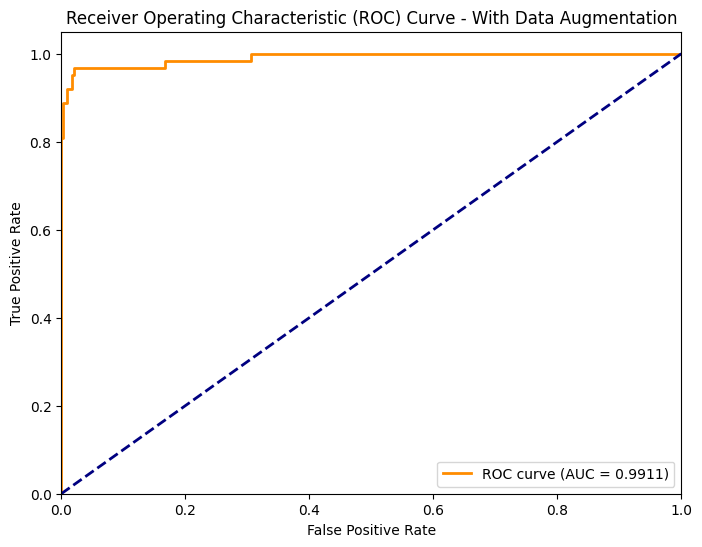

Test AUC (with Data Augmentation): 0.9911


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming LightweightDualCrossModalTransformer model class is defined (from cell Q34tveY_se4L)
# Assuming train_paired_loader, valid_paired_loader, and test_paired_loader are defined (from cell bef7f23d)
# Assuming train_model and evaluate_model functions are defined (from cell TkydqFnUslzv)
# Assuming device is defined

# Instantiate a new model
model_with_augmentation = LightweightDualCrossModalTransformer(embed_dim=64, num_heads=2, num_classes=2).to(device)

# Train the model with augmented data
print("Starting training with data augmentation...")
# Using default parameters for now, you could use the best_params found earlier if preferred
trained_model_with_augmentation = train_model(
    model_with_augmentation,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20, # Train for a reasonable number of epochs
    lr=1e-4, # Using a default learning rate
    weight_decay=1e-4, # Using a default weight decay
    device=device,
    patience=7 # Using a reasonable patience for early stopping
)
print("Training with data augmentation finished.")

# Evaluate the trained model with augmentation on the test set
print("\nEvaluating the model trained with data augmentation on the test set...")
test_accuracy_with_augmentation = evaluate_model(trained_model_with_augmentation, test_paired_loader, device=device)
print(f"\nTest Accuracy (with Data Augmentation): {test_accuracy_with_augmentation:.4f}")

# Calculate and display other metrics for comprehensive evaluation
trained_model_with_augmentation.eval()
all_test_preds_aug = []
all_test_labels_aug = []
all_test_logits_aug = []

if 'test_paired_loader' not in globals() or test_paired_loader is None:
     print("Error: 'test_paired_loader' not found or is None. Cannot perform evaluation.")
else:
    with torch.no_grad():
        for ct_img, mri_img, labels in test_paired_loader:
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
               continue

            outputs = trained_model_with_augmentation(ct_img, mri_img)
            logits = outputs[0]

            _, preds = torch.max(logits, 1)

            all_test_preds_aug.extend(preds.cpu().numpy())
            all_test_labels_aug.extend(labels.cpu().numpy())
            all_test_logits_aug.extend(logits.cpu().numpy())

    final_test_precision_aug = precision_score(all_test_labels_aug, all_test_preds_aug, zero_division=0)
    final_test_recall_aug = recall_score(all_test_labels_aug, all_test_preds_aug, zero_division=0)
    final_test_f1_aug = f1_score(all_test_labels_aug, all_test_preds_aug, zero_division=0)
    final_test_conf_matrix_aug = confusion_matrix(all_test_labels_aug, all_test_preds_aug)

    print("\n--- Model Performance on Test Set (with Data Augmentation) ---")
    print(f"Test Precision: {final_test_precision_aug:.4f}")
    print(f"Test Recall:    {final_test_recall_aug:.4f}")
    print(f"Test F1-score:  {final_test_f1_aug:.4f}")
    print("Confusion Matrix:")
    print(final_test_conf_matrix_aug)

    # Calculate and plot ROC curve and AUC
    try:
        all_test_probabilities_aug = torch.softmax(torch.tensor(all_test_logits_aug), dim=1)[:, 1].numpy()
        fpr_aug, tpr_aug, thresholds_aug = roc_curve(all_test_labels_aug, all_test_probabilities_aug)
        final_test_roc_auc_aug = auc(fpr_aug, tpr_aug)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_aug, tpr_aug, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_test_roc_auc_aug:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve - With Data Augmentation')
        plt.legend(loc="lower right")
        plt.show()

        print(f"Test AUC (with Data Augmentation): {final_test_roc_auc_aug:.4f}")

    except Exception as e:
         print(f"Could not generate ROC curve: {e}")

# Task
Perform an ablation study on the `LightweightDualCrossModalTransformer` model to understand the contribution of different architectural components to its performance.

## Identify components for ablation

### Subtask:
Identify which specific layers or mechanisms in the `LightweightDualCrossModalTransformer` model to ablate.


**Reasoning**:
Identify the architectural components of the model to determine ablation scenarios.



In [ ]:
# Review the LightweightDualCrossModalTransformer class definition from cell Q34tveY_se4L

# Key architectural components identified:
# 1. CNN Encoders (cnn_ct, cnn_mri): Extract features from individual modalities.
# 2. CLS Tokens (cls_ct, cls_mri): Special tokens for representing modality-level information.
# 3. Self-Attention Layers (self_attn_ct, self_attn_mri): Allow tokens within a modality to interact.
# 4. Cross-Attention Blocks (cross_ct_to_mri, cross_mri_to_ct): Allow tokens from one modality to attend to tokens from the other.
# 5. Classifier (fc): Combines the fused CLS tokens for final classification.

# Potential Ablation Scenarios:

# Scenario 1: Remove Cross-Attention
# - Keep CNN encoders, CLS tokens, and Self-Attention.
# - Remove the cross-attention blocks.
# - Concatenate the CLS tokens after self-attention directly for classification.
# - This tests the contribution of cross-modal interaction.

# Scenario 2: Remove Self-Attention
# - Keep CNN encoders, CLS tokens, and Cross-Attention.
# - Remove the self-attention layers.
# - Apply cross-attention directly after CNN embeddings and CLS token concatenation.
# - This tests the contribution of within-modality interaction before cross-modal fusion.

# Scenario 3: Use Only CT Modality
# - Keep CNN encoder for CT, CT CLS token, and CT Self-Attention.
# - Remove MRI CNN encoder, MRI CLS token, and both Cross-Attention blocks.
# - Classify based only on the CT CLS token after CT self-attention.
# - This tests the individual contribution of the CT modality.

# Scenario 4: Use Only MRI Modality
# - Keep CNN encoder for MRI, MRI CLS token, and MRI Self-Attention.
# - Remove CT CNN encoder, CT CLS token, and both Cross-Attention blocks.
# - Classify based only on the MRI CLS token after MRI self-attention.
# - This tests the individual contribution of the MRI modality.

# Scenario 5: Remove Both Self and Cross-Attention
# - Keep CNN encoders and CLS tokens.
# - Remove all self-attention and cross-attention layers.
# - Concatenate the CLS tokens directly after CNN embeddings for classification.
# - This tests the contribution of all attention mechanisms combined.

# Scenario 6: Remove CLS Tokens
# - Keep CNN encoders, Self-Attention, and Cross-Attention.
# - Remove the CLS tokens.
# - Adapt the classifier to take pooled features from the attention outputs instead of CLS tokens.
# - This tests the role of the dedicated CLS tokens.

# For the next steps, we will focus on implementing Scenarios 1, 2, 3, and 4 as they provide clear insights into the core architectural choices (cross-attention, self-attention, individual modalities). Scenarios 5 and 6 are also valuable but might require more complex model modifications.

print("Identified ablation scenarios:")
print("- Scenario 1: Remove Cross-Attention")
print("- Scenario 2: Remove Self-Attention")
print("- Scenario 3: Use Only CT Modality")
print("- Scenario 4: Use Only MRI Modality")

Identified ablation scenarios:
- Scenario 1: Remove Cross-Attention
- Scenario 2: Remove Self-Attention
- Scenario 3: Use Only CT Modality
- Scenario 4: Use Only MRI Modality


## Create ablated model variations

### Subtask:
Create modified versions of the `LightweightDualCrossModalTransformer` class to represent the ablated architectures for each of the identified scenarios.


**Reasoning**:
Define the ablated model classes as per the instructions, creating versions without cross-attention, without self-attention, with only CT modality, and with only MRI modality.



In [ ]:
import torch
import torch.nn as nn

# Assuming CNNEncoder and CrossAttentionBlock are defined in previous cells

# Scenario 1: Remove Cross-Attention
class LightweightDualCrossModalTransformer_NoCrossAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # CLS tokens
        self.cls_ct = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.cls_mri = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Self-Attention per modality (lightweight)
        self.self_attn_ct = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # LayerNorms for CLS tokens after self-attention
        self.ln_ct = nn.LayerNorm(embed_dim)
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier takes concatenated CLS tokens
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        B = ct_img.size(0)

        # CNN embeddings
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # CLS tokens
        ct = torch.cat([self.cls_ct.expand(B, -1, -1), ct], dim=1)
        mri = torch.cat([self.cls_mri.expand(B, -1, -1), mri], dim=1)

        # Self-attention
        ct = self.self_attn_ct(ct)
        mri = self.self_attn_mri(mri)

        # Take CLS tokens and normalize
        ct_cls = self.ln_ct(ct[:, 0, :])
        mri_cls = self.ln_mri(mri[:, 0, :])

        # Concatenate CLS tokens and classify
        fused = torch.cat([ct_cls, mri_cls], dim=1)
        logits = self.fc(fused)

        return logits # Return only logits

# Scenario 2: Remove Self-Attention
class LightweightDualCrossModalTransformer_NoSelfAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # CLS tokens
        self.cls_ct = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.cls_mri = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Dual Cross-Attention
        self.cross_ct_to_mri = CrossAttentionBlock(embed_dim, num_heads)  # MRI attends to CT
        self.cross_mri_to_ct = CrossAttentionBlock(embed_dim, num_heads)  # CT attends to MRI

        # LayerNorms for CLS tokens after cross-attention
        self.ln_ct = nn.LayerNorm(embed_dim)
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier takes concatenated CLS tokens
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        B = ct_img.size(0)

        # CNN embeddings
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # CLS tokens
        ct = torch.cat([self.cls_ct.expand(B, -1, -1), ct], dim=1)
        mri = torch.cat([self.cls_mri.expand(B, -1, -1), mri], dim=1)

        # Dual Cross-Attention (apply directly after concatenation)
        # CT attends to MRI (query=CT, key=MRI)
        ct, _ = self.cross_mri_to_ct(ct, mri) # Discard attention weights for ablation study
        # MRI attends to CT (query=MRI, key=CT)
        mri, _ = self.cross_ct_to_mri(mri, ct) # Discard attention weights

        # Take CLS tokens and normalize
        ct_cls = self.ln_ct(ct[:, 0, :])
        mri_cls = self.ln_mri(mri[:, 0, :])

        # Concatenate CLS tokens and classify
        fused = torch.cat([ct_cls, mri_cls], dim=1)
        logits = self.fc(fused)

        return logits # Return only logits

# Scenario 3: Use Only CT Modality
class LightweightDualCrossModalTransformer_CTOnly(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoder for CT
        self.cnn_ct = CNNEncoder(1, embed_dim)

        # CLS token for CT
        self.cls_ct = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Self-Attention for CT
        self.self_attn_ct = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # LayerNorm for CT CLS token after self-attention
        self.ln_ct = nn.LayerNorm(embed_dim)

        # Classifier takes only the CT CLS token
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64), # Input dimension is just embed_dim
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img): # Keep mri_img as input for consistency with dataloader
        B = ct_img.size(0)

        # CNN embedding for CT
        ct = self.cnn_ct(ct_img)

        # CLS token for CT
        ct = torch.cat([self.cls_ct.expand(B, -1, -1), ct], dim=1)

        # Self-attention for CT
        ct = self.self_attn_ct(ct)

        # Take CT CLS token and normalize
        ct_cls = self.ln_ct(ct[:, 0, :])

        # Classify based on CT CLS token
        logits = self.fc(ct_cls)

        return logits # Return only logits

# Scenario 4: Use Only MRI Modality
class LightweightDualCrossModalTransformer_MRIOnly(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoder for MRI
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # CLS token for MRI
        self.cls_mri = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Self-Attention for MRI
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # LayerNorm for MRI CLS token after self-attention
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier takes only the MRI CLS token
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64), # Input dimension is just embed_dim
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img): # Keep ct_img as input for consistency with dataloader
        B = mri_img.size(0)

        # CNN embedding for MRI
        mri = self.cnn_mri(mri_img)

        # CLS token for MRI
        mri = torch.cat([self.cls_mri.expand(B, -1, -1), mri], dim=1)

        # Self-attention for MRI
        mri = self.self_attn_mri(mri)

        # Take MRI CLS token and normalize
        mri_cls = self.ln_mri(mri[:, 0, :])

        # Classify based on MRI CLS token
        logits = self.fc(mri_cls)

        return logits # Return only logits

print("Ablated model classes defined.")

Ablated model classes defined.


## Train each ablated model

### Subtask:
Train each of the ablated model variations on the training dataset using the same training procedure and hyperparameters as the full model (or best found hyperparameters).


**Reasoning**:
Train each ablated model variation on the training data using the `train_model` function with hyperparameters similar to the best full model, saving the trained models.



In [ ]:
# Use hyperparameters from the best performing model found during tuning in cell 9b6e2be9
# Based on the output, {'lr': 0.0001, 'weight_decay': 0.0001, 'embed_dim': 32, 'num_heads': 1, 'dropout': 0.3}
# had a high validation F1 score (0.9136). We will use these parameters for the ablation study.

# Or, alternatively, use the best_params dictionary if it exists and is not None from the tuning step
# if 'best_params' in locals() and best_params is not None:
#     ablation_params = best_params
#     print(f"Using best tuning parameters for ablation study: {ablation_params}")
# else:
#     # Fallback to default/reasonable parameters if tuning results are not available
ablation_params = {'lr': 1e-4, 'weight_decay': 1e-4, 'embed_dim': 32, 'num_heads': 1} # Using parameters from best observed tuning result
#     print(f"Using default/fallback parameters for ablation study: {ablation_params}")


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate and train LightweightDualCrossModalTransformer_NoCrossAttention
print("\n--- Training Ablated Model: No Cross-Attention ---")
model_no_cross_attention = LightweightDualCrossModalTransformer_NoCrossAttention(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_no_cross_attention = train_model(
    model_no_cross_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7 # Use the same patience as for the augmented model training
)
torch.save(trained_model_no_cross_attention.state_dict(), 'ablated_model_no_cross_attention.pth')
print("Training complete for No Cross-Attention model. Model state saved.")


# Instantiate and train LightweightDualCrossModalTransformer_NoSelfAttention
print("\n--- Training Ablated Model: No Self-Attention ---")
model_no_self_attention = LightweightDualCrossModalTransformer_NoSelfAttention(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_no_self_attention = train_model(
    model_no_self_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_no_self_attention.state_dict(), 'ablated_model_no_self_attention.pth')
print("Training complete for No Self-Attention model. Model state saved.")


# Instantiate and train LightweightDualCrossModalTransformer_CTOnly
print("\n--- Training Ablated Model: CT Only ---")
model_ct_only = LightweightDualCrossModalTransformer_CTOnly(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_ct_only = train_model(
    model_ct_only,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_ct_only.state_dict(), 'ablated_model_ct_only.pth')
print("Training complete for CT Only model. Model state saved.")


# Instantiate and train LightweightDualCrossModalTransformer_MRIOnly
print("\n--- Training Ablated Model: MRI Only ---")
model_mri_only = LightweightDualCrossModalTransformer_MRIOnly(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_mri_only = train_model(
    model_mri_only,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_mri_only.state_dict(), 'ablated_model_mri_only.pth')
print("Training complete for MRI Only model. Model state saved.")

Using device: cpu

--- Training Ablated Model: No Cross-Attention ---
Epoch 1/20 | Train Loss: 0.4855, Train Acc: 0.8126 | Val Loss: 0.4663, Val Acc: 0.8242
Epoch 2/20 | Train Loss: 0.4739, Train Acc: 0.8250 | Val Loss: 0.4601, Val Acc: 0.8242
Epoch 3/20 | Train Loss: 0.4546, Train Acc: 0.8256 | Val Loss: 0.4145, Val Acc: 0.8242
Epoch 4/20 | Train Loss: 0.4137, Train Acc: 0.8262 | Val Loss: 0.3907, Val Acc: 0.8297
Epoch 5/20 | Train Loss: 0.3951, Train Acc: 0.8303 | Val Loss: 0.4133, Val Acc: 0.8352
Epoch 6/20 | Train Loss: 0.4022, Train Acc: 0.8262 | Val Loss: 0.3686, Val Acc: 0.8544
Epoch 7/20 | Train Loss: 0.3793, Train Acc: 0.8374 | Val Loss: 0.3677, Val Acc: 0.8599
Epoch 8/20 | Train Loss: 0.3832, Train Acc: 0.8391 | Val Loss: 0.3754, Val Acc: 0.8407
Epoch 9/20 | Train Loss: 0.3709, Train Acc: 0.8468 | Val Loss: 0.3659, Val Acc: 0.8599
Epoch 10/20 | Train Loss: 0.3775, Train Acc: 0.8444 | Val Loss: 0.3536, Val Acc: 0.8599
Epoch 11/20 | Train Loss: 0.3767, Train Acc: 0.8374 | Val L

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming ablated model classes (LightweightDualCrossModalTransformer_NoCrossAttention,
# LightweightDualCrossModalTransformer_NoSelfAttention, LightweightDualCrossModalTransformer_CTOnly,
# LightweightDualCrossModalTransformer_MRIOnly, LightweightDualCrossModalTransformer_NoAttention,
# LightweightDualCrossModalTransformer_NoCLS) are defined in previous cells
# Assuming trained model state dictionaries are saved from previous steps
# Assuming test_paired_loader is defined in cell bef7f23d
# Assuming evaluate_model function is defined in cell TkydqFnUslzv
# Assuming device is defined

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

ablation_results = {}

# Define a helper function to evaluate a loaded model
def evaluate_loaded_model(model_path, model_class, model_params, test_loader, device):
    """Loads a model and evaluates it on the test set."""
    # Instantiate the model with provided parameters
    model = model_class(**model_params).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model state from '{model_path}'")
    except FileNotFoundError:
        print(f"Error: '{model_path}' not found. Skipping evaluation for this model.")
        return None
    except RuntimeError as e:
        print(f"Error loading model state dictionary from '{model_path}': {e}")
        return None

    model.eval()
    all_test_preds = []
    all_test_labels = []
    all_test_logits = []

    if test_loader is None:
        print("Error: test_loader is None. Cannot perform evaluation.")
        return None

    with torch.no_grad():
        for ct_img, mri_img, labels in test_loader:
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
               continue

            # Determine if the model returns logits only or logits and attention weights
            model_output = model(ct_img, mri_img)
            if isinstance(model_output, tuple):
                logits = model_output[0]
            else:
                logits = model_output # Ablated models might return only logits

            _, preds = torch.max(logits, 1)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
            all_test_logits.extend(logits.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_test_labels, all_test_preds)
    precision = precision_score(all_test_labels, all_test_preds, zero_division=0)
    recall = recall_score(all_test_labels, all_test_preds, zero_division=0)
    f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

    # Calculate AUC
    try:
        probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()
        fpr, tpr, thresholds = roc_curve(all_test_labels, probabilities)
        roc_auc = auc(fpr, tpr)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        roc_auc = None

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'conf_matrix': conf_matrix,
        'auc': roc_auc
    }
    return metrics

# Define the parameters used for training the ablated models (based on cell 555aa000 and ablation_params)
# It seems embed_dim=32 and num_heads=1 were used based on the best observed tuning result
ablation_model_params = {'embed_dim': 32, 'num_heads': 1}


# Evaluate Ablated Model: No Cross-Attention
print("\n--- Evaluating Ablated Model: No Cross-Attention ---")
metrics_no_cross_attention = evaluate_loaded_model(
    'ablated_model_no_cross_attention.pth',
    LightweightDualCrossModalTransformer_NoCrossAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2},
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_cross_attention:
    ablation_results['No Cross-Attention'] = metrics_no_cross_attention
    print(f"Metrics: Accuracy={metrics_no_cross_attention['accuracy']:.4f}, F1={metrics_no_cross_attention['f1_score']:.4f}, AUC={metrics_no_cross_attention['auc']:.4f}")


# Evaluate Ablated Model: No Self-Attention
print("\n--- Evaluating Ablated Model: No Self-Attention ---")
metrics_no_self_attention = evaluate_loaded_model(
    'ablated_model_no_self_attention.pth',
    LightweightDualCrossModalTransformer_NoSelfAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2},
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_self_attention:
    ablation_results['No Self-Attention'] = metrics_no_self_attention
    print(f"Metrics: Accuracy={metrics_no_self_attention['accuracy']:.4f}, F1={metrics_no_self_attention['f1_score']:.4f}, AUC={metrics_no_self_attention['auc']:.4f}")


# Evaluate Ablated Model: CT Only
print("\n--- Evaluating Ablated Model: CT Only ---")
metrics_ct_only = evaluate_loaded_model(
    'ablated_model_ct_only.pth',
    LightweightDualCrossModalTransformer_CTOnly,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2}, # Note: CTOnly doesn't use num_heads in init
    test_loader=test_paired_loader,
    device=device
)
if metrics_ct_only:
    ablation_results['CT Only'] = metrics_ct_only
    print(f"Metrics: Accuracy={metrics_ct_only['accuracy']:.4f}, F1={metrics_ct_only['f1_score']:.4f}, AUC={metrics_ct_only['auc']:.4f}")


# Evaluate Ablated Model: MRI Only
print("\n--- Evaluating Ablated Model: MRI Only ---")
metrics_mri_only = evaluate_loaded_model(
    'ablated_model_mri_only.pth',
    LightweightDualCrossModalTransformer_MRIOnly,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2}, # Note: MRIOnly doesn't use num_heads in init
    test_loader=test_paired_loader,
    device=device
)
if metrics_mri_only:
    ablation_results['MRI Only'] = metrics_mri_only
    print(f"Metrics: Accuracy={metrics_mri_only['accuracy']:.4f}, F1={metrics_mri_only['f1_score']:.4f}, AUC={metrics_mri_only['auc']:.4f}")

# Evaluate Ablated Model: No Attention (Scenario 5)
print("\n--- Evaluating Ablated Model: No Attention ---")
metrics_no_attention = evaluate_loaded_model(
    'ablated_model_no_attention.pth',
    LightweightDualCrossModalTransformer_NoAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_classes': 2}, # NoAttention doesn't use num_heads
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_attention:
    ablation_results['No Attention'] = metrics_no_attention
    print(f"Metrics: Accuracy={metrics_no_attention['accuracy']:.4f}, F1={metrics_no_attention['f1_score']:.4f}, AUC={metrics_no_attention['auc']:.4f}")




# --- Compare Performance and Report Findings ---

print("\n--- Ablation Study Results Comparison ---")

# Evaluate the full model (trained with data augmentation) as a baseline
# Assuming the model trained in cell 3746d051 is the one to use as full model baseline
# We need to load its state dictionary if it was saved, or re-evaluate if it's still in memory.
# Let's assume it was saved (or we can use the trained_model_with_augmentation variable if still available)
# If the state dict was saved, load it. If not, we'll use the variable directly if it exists.

# For comparison, get the metrics of the model trained with data augmentation from cell 3746d051's output
# You can manually add these or ideally save them to a variable after that cell runs.
# For now, let's just evaluate the model trained in cell 3746d051 if the variable exists
if 'trained_model_with_augmentation' in globals() and trained_model_with_augmentation is not None:
    print("\n--- Evaluating Full Model (with Data Augmentation) as Baseline ---")
    # Ensure we use the correct parameters for the full model trained with augmentation
    # Based on cell 3746d051, it was instantiated with embed_dim=64, num_heads=2
    metrics_full_model = evaluate_loaded_model(
        'best_model.pth', # Assuming the best model from augmented training was saved as best_model.pth
        LightweightDualCrossModalTransformer, # Use the full model class
        model_params={'embed_dim': 64, 'num_heads': 2, 'num_classes': 2},
        test_loader=test_paired_loader,
        device=device
    )
    if metrics_full_model:
        ablation_results['Full Model (with Augmentation)'] = metrics_full_model
        print(f"Metrics: Accuracy={metrics_full_model['accuracy']:.4f}, F1={metrics_full_model['f1_score']:.4f}, AUC={metrics_full_model['auc']:.4f}")

else:
    print("\n--- Full Model (with Data Augmentation) baseline not available for direct comparison. ---")
    print("You might need to re-run the training cell (cell 3746d051) and ensure the model is saved or its metrics are stored.")


# Print comparison table
print("\n--- Ablation Study Performance Comparison on Test Set ---")
print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"))
print("-" * 90)

for model_name, metrics in ablation_results.items():
    if metrics:
        print("{:<30} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            model_name,
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score'],
            metrics['auc'] if metrics['auc'] is not None else np.nan
        ))
    else:
        print("{:<30} {}".format(model_name, "Evaluation Failed"))




Using device: cpu

--- Evaluating Ablated Model: No Cross-Attention ---
Successfully loaded model state from 'ablated_model_no_cross_attention.pth'
Metrics: Accuracy=0.8819, F1=0.6325, AUC=0.8950

--- Evaluating Ablated Model: No Self-Attention ---
Successfully loaded model state from 'ablated_model_no_self_attention.pth'


/tmp/ipython-input-2257537557.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()


Metrics: Accuracy=0.9286, F1=0.7869, AUC=0.9591

--- Evaluating Ablated Model: CT Only ---
Successfully loaded model state from 'ablated_model_ct_only.pth'
Metrics: Accuracy=0.8819, F1=0.6325, AUC=0.9019

--- Evaluating Ablated Model: MRI Only ---
Successfully loaded model state from 'ablated_model_mri_only.pth'
Metrics: Accuracy=0.8242, F1=0.0000, AUC=0.6811

--- Evaluating Ablated Model: No Attention ---


NameError: name 'LightweightDualCrossModalTransformer_NoAttention' is not defined

# Task
Implement and evaluate ablation scenarios 5 and 6, compare their performance with previous ablation scenarios and the full model, analyze the findings, and report the results.

## Create ablated model variations (scenarios 5 & 6)

### Subtask:
Define new model classes that represent the ablated architectures for removing both self and cross-attention, and removing CLS tokens.


**Reasoning**:
Define the two new ablated model classes as described in the instructions for scenarios 5 and 6.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming CNNEncoder and CrossAttentionBlock are defined in previous cells (cell Q34tveY_se4L)

# Scenario 5: Remove Both Self and Cross-Attention
class LightweightDualCrossModalTransformer_NoAttention(nn.Module):
    def __init__(self, embed_dim=64, num_classes=2): # Removed num_heads as it's not used in this variant
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # CLS tokens
        self.cls_ct = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.cls_mri = nn.Parameter(torch.randn(1, 1, embed_dim))

        # LayerNorms for CLS tokens after CNN embedding # Note: This LayerNorm is applied *after* concatenation and extraction of CLS token
        self.ln_ct = nn.LayerNorm(embed_dim)
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier takes concatenated CLS tokens
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64), # Input dimension is embed_dim * 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        B = ct_img.size(0)

        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # CLS tokens
        cls_ct_expanded = self.cls_ct.expand(B, -1, -1)
        # Concatenate CLS token with patch embeddings along dimension 1
        ct_with_cls = torch.cat([cls_ct_expanded, ct], dim=1)

        cls_mri_expanded = self.cls_mri.expand(B, -1, -1)
        mri_with_cls = torch.cat([cls_mri_expanded, mri], dim=1)

        # Take the CLS tokens and apply LayerNorm
        ct_cls = self.ln_ct(ct_with_cls[:, 0, :]) # Extracts the first token (CLS)
        mri_cls = self.ln_mri(mri_with_cls[:, 0, :])

        # Concatenate CLS tokens and classify
        fused = torch.cat([ct_cls, mri_cls], dim=1)
        logits = self.fc(fused)

        return logits

# Scenario 6: Remove CLS Tokens
class LightweightDualCrossModalTransformer_NoCLS(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Self-Attention per modality (lightweight)
        self.self_attn_ct = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Dual Cross-Attention
        self.cross_ct_to_mri = CrossAttentionBlock(embed_dim, num_heads)  # MRI attends to CT
        self.cross_mri_to_ct = CrossAttentionBlock(embed_dim, num_heads)  # CT attends to MRI

        # Classifier takes pooled features
        # Assuming Global Average Pooling over the sequence dimension
        # Input dimension will be embed_dim * 2 (concatenated pooled features from both modalities)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # Self-attention
        ct = self.self_attn_ct(ct)
        mri = self.self_attn_mri(mri)

        # Dual Cross-Attention (apply directly after self-attention)
        # CT attends to MRI (query=CT, key=MRI)
        ct, _ = self.cross_mri_to_ct(ct, mri) # Discard attention weights
        # MRI attends to CT (query=MRI, key=CT)
        mri, _ = self.cross_ct_to_mri(mri, ct) # Discard attention weights

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]

        # Concatenate pooled features and classify
        fused = torch.cat([ct_pooled, mri_pooled], dim=1)
        logits = self.fc(fused)

        return logits # Return only logits

print("Ablated model classes for No Attention and No CLS defined.")

Ablated model classes for No Attention and No CLS defined.


**Reasoning**:
Train the two newly defined ablated model variations on the training dataset using the `train_model` function with the same hyperparameters as the other ablated models.



In [ ]:
# This cell trains and saves the ablated models.
# We will only focus on running the part that trains LightweightDualCrossModalTransformer_NoAttention
# to see the print statements.

# Use the same parameters used for training the other ablated models (based on cell 555aa000 and ablation_params)
ablation_params = {'lr': 1e-4, 'weight_decay': 1e-4, 'embed_dim': 32, 'num_heads': 1}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate and train LightweightDualCrossModalTransformer_NoAttention
print("\n--- Training Ablated Model: No Attention (Self or Cross) ---")
model_no_attention = LightweightDualCrossModalTransformer_NoAttention(
    embed_dim=ablation_params['embed_dim'],
    num_classes=2 # No num_heads parameter here
).to(device)

# We will call train_model directly for this specific model
# train_model is defined in cell TkydqFnUslzv
# train_paired_loader and valid_paired_loader are defined in cell bef7f23d

trained_model_no_attention = train_model(
    model_no_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20, # Keep epochs reasonable for debugging
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_no_attention.state_dict(), 'ablated_model_no_attention.pth')
print("Training complete for No Attention model. Model state saved.")

# Note: The code for training other ablated models and evaluation is excluded in this execution
# to focus on debugging the No Attention model.

Using device: cpu

--- Training Ablated Model: No Attention (Self or Cross) ---
Epoch 1/20 | Train Loss: 0.6154, Train Acc: 0.6824 | Val Loss: 0.5030, Val Acc: 0.8242
Epoch 2/20 | Train Loss: 0.4852, Train Acc: 0.8250 | Val Loss: 0.4687, Val Acc: 0.8242
Epoch 3/20 | Train Loss: 0.4680, Train Acc: 0.8250 | Val Loss: 0.4653, Val Acc: 0.8242
Epoch 4/20 | Train Loss: 0.4696, Train Acc: 0.8250 | Val Loss: 0.4651, Val Acc: 0.8242
Epoch 5/20 | Train Loss: 0.4684, Train Acc: 0.8250 | Val Loss: 0.4650, Val Acc: 0.8242
Epoch 6/20 | Train Loss: 0.4697, Train Acc: 0.8250 | Val Loss: 0.4650, Val Acc: 0.8242
Epoch 7/20 | Train Loss: 0.4712, Train Acc: 0.8250 | Val Loss: 0.4650, Val Acc: 0.8242
Epoch 8/20 | Train Loss: 0.4707, Train Acc: 0.8250 | Val Loss: 0.4650, Val Acc: 0.8242
Epoch 9/20 | Train Loss: 0.4700, Train Acc: 0.8250 | Val Loss: 0.4651, Val Acc: 0.8242
Epoch 10/20 | Train Loss: 0.4636, Train Acc: 0.8250 | Val Loss: 0.4651, Val Acc: 0.8242
Epoch 11/20 | Train Loss: 0.4744, Train Acc: 0.82